# clone detection

In [5]:
import gzip, time
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import seaborn as sns
from Bio.Seq import Seq
from collections import Counter
import os
import cassiopeia as cas
from cassiopeia.mixins import logger
from typing import Dict, List, Tuple
from cassiopeia.preprocess import (
    alignment_utilities,
    constants,
    map_utils,
    doublet_utils,
    lineage_utils,
    UMI_utils,
    utilities,
)

import gzip, time
import pickle as pic

In [90]:
umi_table = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/cassiopeia_result/staticBC/umi_table_filtered.csv',
                               sep=',',index_col=0,header=0,keep_default_na=False)

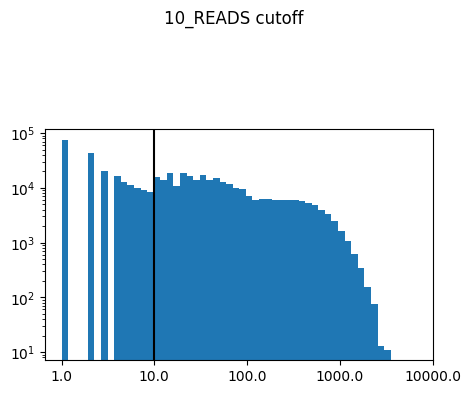

In [91]:
plt.figure(figsize=(5,3))
plt.hist(np.log(umi_table['readCount'])/np.log(10), bins=50)
plt.axvline(np.log(10)/np.log(10),c='k')
plt.xticks(range(5),np.logspace(0,4,5))
plt.text(np.log(10)/np.log(10)*1.1,10**7,'10_READS cutoff', fontsize=12)
plt.yscale('log')

In [92]:
umi_table.shape

(481880, 8)

In [93]:
umi_table = umi_table[umi_table['readCount'] >= 10]
#umi_table = umi_table[umi_table['readCount'] >= 5]

In [94]:
umi_table.shape

(327557, 8)

In [95]:
umi_table.head()

,readName,UMI,cellBC,grpFlag,intBC,qual,readCount,seq
0,AAAAAAAAAACCGTTCCAGAAACTC_CGGATGAACC_36,CGGATGAACC,AAAAAAAAAACCGTTCCAGAAACTC,0,staticBC,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,36,ACGATCATCTGACAGTCACTGTGACGCACTTTTTTCTAGATGAGAA...
1,AAAAAAAAAGATTGACGAGTCTAAG_TGCTTGTCCG_31,TGCTTGTCCG,AAAAAAAAAGATTGACGAGTCTAAG,0,staticBC,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,31,ACGATCATCTGACAGTCACTGTGACGCACTTTTTGGACGCGGAGCG...
2,AAAAAAACACGCGACTAATGCCAGC_TCCTTGTATC_26,TCCTTGTATC,AAAAAAACACGCGACTAATGCCAGC,0+,staticBC,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,26,ACGATCATCTGACAGTCACTGTGACGCACTTTTTGGGGGGGCCGCA...
4,AAAAAAACACTGGCATCCGGCTTCG_ATCCGCCTGA_384,ATCCGCCTGA,AAAAAAACACTGGCATCCGGCTTCG,0+,staticBC,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,384,ACGATCATCTGACAGTCACTGTGACGCACTTTTTGGCGTGTAGGCC...
6,AAAAAAACATTAGGCACTACGCCCA_CGTAGACGAC_11,CGTAGACGAC,AAAAAAACATTAGGCACTACGCCCA,0,staticBC,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,11,ACGATCATCTGACAGTCACTGTGACGCACTTTTTCCAAATCGGACA...


In [96]:
def is_valid(bc):
    return (bc[0:8]=='CACTTTTT' and bc[22:27]=='AAAAG') or (bc[0:28]=='CACTTTTTTCTAGATGAGAAGCGAAAAG')

    
def is_valid_staticBC_prefix(r2_line): # need to 1 mismatch
    staticBC_prefix = 'ATCTGACAGTCACTGTGACG'
    return staticBC_prefix in r2_line

In [97]:
staticBC_prefix = 'ATCTGACAGTCACTGTGACG'
umi_table['umi_valid'] = 'F'
umi_table['intBC'] = 'None'
counter = 0
for i in range(0,len(umi_table.index)):
    counter += 1
    if counter % 100000 == 0: print(counter)
    
    seq = umi_table.iloc[i,7]
    if is_valid_staticBC_prefix(seq): 
        seq_sub = seq.split(staticBC_prefix)[1][:31]
        if is_valid(seq_sub):
            umi_table.iloc[i,8] = 'T'
            if seq_sub[0:28]=='CACTTTTTTCTAGATGAGAAGCGAAAAG':
                staticBC = 'TCTAGATGAGAAGCG'
            else:
                staticBC = seq_sub[8:22] 
            umi_table.iloc[i,4] = staticBC

100000
200000
300000


In [98]:
umi_table = umi_table[umi_table['umi_valid']=='T']

In [99]:
umi_table

,readName,UMI,cellBC,grpFlag,intBC,qual,readCount,seq,umi_valid
0,AAAAAAAAAACCGTTCCAGAAACTC_CGGATGAACC_36,CGGATGAACC,AAAAAAAAAACCGTTCCAGAAACTC,0,TCTAGATGAGAAGCG,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,36,ACGATCATCTGACAGTCACTGTGACGCACTTTTTTCTAGATGAGAA...,T
1,AAAAAAAAAGATTGACGAGTCTAAG_TGCTTGTCCG_31,TGCTTGTCCG,AAAAAAAAAGATTGACGAGTCTAAG,0,GGACGCGGAGCGGG,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,31,ACGATCATCTGACAGTCACTGTGACGCACTTTTTGGACGCGGAGCG...,T
2,AAAAAAACACGCGACTAATGCCAGC_TCCTTGTATC_26,TCCTTGTATC,AAAAAAACACGCGACTAATGCCAGC,0+,GGGGGGGCCGCAAG,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,26,ACGATCATCTGACAGTCACTGTGACGCACTTTTTGGGGGGGCCGCA...,T
4,AAAAAAACACTGGCATCCGGCTTCG_ATCCGCCTGA_384,ATCCGCCTGA,AAAAAAACACTGGCATCCGGCTTCG,0+,GGCGTGTAGGCCCT,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,384,ACGATCATCTGACAGTCACTGTGACGCACTTTTTGGCGTGTAGGCC...,T
6,AAAAAAACATTAGGCACTACGCCCA_CGTAGACGAC_11,CGTAGACGAC,AAAAAAACATTAGGCACTACGCCCA,0,CCAAATCGGACATT,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,11,ACGATCATCTGACAGTCACTGTGACGCACTTTTTCCAAATCGGACA...,T
...,...,...,...,...,...,...,...,...,...
481869,TTTTTTTTCACCAGCGCGACTATCA_CCGAGCTTTC_216,CCGAGCTTTC,TTTTTTTTCACCAGCGCGACTATCA,0+,GTGCAACGTGTTGG,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,216,ACGATCATCTGACAGTCACTGTGACGCACTTTTTGTGCAACGTGTT...,T
481872,TTTTTTTTGCGGACGCTCGAATATG_CACGGCGAAT_100,CACGGCGAAT,TTTTTTTTGCGGACGCTCGAATATG,0,TCTAGATGAGAAGCG,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,100,ACGATCATCTGACAGTCACTGTGACGCACTTTTTTCTAGATGAGAA...,T
481874,TTTTTTTTTAGCACGCTACCTATCA_CACGCTACTG_227,CACGCTACTG,TTTTTTTTTAGCACGCTACCTATCA,0+,GGCGCCAAACTCAG,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,227,ACGATCATCTGACAGTCACTGTGACGCACTTTTTGGCGCCAAACTC...,T
481875,TTTTTTTTTAGCACGCTACCTATCA_CGGCGGTCGA_134,CGGCGGTCGA,TTTTTTTTTAGCACGCTACCTATCA,0,GGCGCCAAACTCAG,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,134,ACGATCATCTGACAGTCACTGTGACGCACTTTTTGGCGCCAAACTC...,T


In [100]:
barcodeToPos_df = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/barcodeToPos.txt',sep='\t',header=None)
barcodeToPos_df.columns = ['CID','x','y']
barcodeToPos_df['x_y'] = barcodeToPos_df['x'].astype('str') + '_' + barcodeToPos_df['y'].astype('str')
barcodeToPos_dict = barcodeToPos_df.set_index('CID')['x_y'].to_dict()

In [101]:
umi_table['x_y'] = [ barcodeToPos_dict[CID] for CID in umi_table['cellBC'] ]

In [102]:
umi_table

,readName,UMI,cellBC,grpFlag,intBC,qual,readCount,seq,umi_valid,x_y
0,AAAAAAAAAACCGTTCCAGAAACTC_CGGATGAACC_36,CGGATGAACC,AAAAAAAAAACCGTTCCAGAAACTC,0,TCTAGATGAGAAGCG,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,36,ACGATCATCTGACAGTCACTGTGACGCACTTTTTTCTAGATGAGAA...,T,7795_3248
1,AAAAAAAAAGATTGACGAGTCTAAG_TGCTTGTCCG_31,TGCTTGTCCG,AAAAAAAAAGATTGACGAGTCTAAG,0,GGACGCGGAGCGGG,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,31,ACGATCATCTGACAGTCACTGTGACGCACTTTTTGGACGCGGAGCG...,T,8317_8748
2,AAAAAAACACGCGACTAATGCCAGC_TCCTTGTATC_26,TCCTTGTATC,AAAAAAACACGCGACTAATGCCAGC,0+,GGGGGGGCCGCAAG,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,26,ACGATCATCTGACAGTCACTGTGACGCACTTTTTGGGGGGGCCGCA...,T,3749_9988
4,AAAAAAACACTGGCATCCGGCTTCG_ATCCGCCTGA_384,ATCCGCCTGA,AAAAAAACACTGGCATCCGGCTTCG,0+,GGCGTGTAGGCCCT,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,384,ACGATCATCTGACAGTCACTGTGACGCACTTTTTGGCGTGTAGGCC...,T,8586_8454
6,AAAAAAACATTAGGCACTACGCCCA_CGTAGACGAC_11,CGTAGACGAC,AAAAAAACATTAGGCACTACGCCCA,0,CCAAATCGGACATT,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,11,ACGATCATCTGACAGTCACTGTGACGCACTTTTTCCAAATCGGACA...,T,10312_7718
...,...,...,...,...,...,...,...,...,...,...
481869,TTTTTTTTCACCAGCGCGACTATCA_CCGAGCTTTC_216,CCGAGCTTTC,TTTTTTTTCACCAGCGCGACTATCA,0+,GTGCAACGTGTTGG,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,216,ACGATCATCTGACAGTCACTGTGACGCACTTTTTGTGCAACGTGTT...,T,8279_10427
481872,TTTTTTTTGCGGACGCTCGAATATG_CACGGCGAAT_100,CACGGCGAAT,TTTTTTTTGCGGACGCTCGAATATG,0,TCTAGATGAGAAGCG,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,100,ACGATCATCTGACAGTCACTGTGACGCACTTTTTTCTAGATGAGAA...,T,8109_10572
481874,TTTTTTTTTAGCACGCTACCTATCA_CACGCTACTG_227,CACGCTACTG,TTTTTTTTTAGCACGCTACCTATCA,0+,GGCGCCAAACTCAG,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,227,ACGATCATCTGACAGTCACTGTGACGCACTTTTTGGCGCCAAACTC...,T,7072_10203
481875,TTTTTTTTTAGCACGCTACCTATCA_CGGCGGTCGA_134,CGGCGGTCGA,TTTTTTTTTAGCACGCTACCTATCA,0,GGCGCCAAACTCAG,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,134,ACGATCATCTGACAGTCACTGTGACGCACTTTTTGGCGCCAAACTC...,T,7072_10203


In [103]:
'''
gem = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/SPATIAL/T2/B03203C612.tissue.bin50.gem',
            sep='\t',header=0)
gem.columns = ['geneID','x','y','MIDCount','ExonCount','bin50_x','bin50_y','CellID']
gem['CellID'] = gem['CellID'].astype('str')
gem['x_y'] = gem['x'].astype('str') + '_' + gem['y'].astype('str')
gem = gem.drop_duplicates(subset='x_y',keep='first')
'''

"\ngem = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/SPATIAL/T2/B03203C612.tissue.bin50.gem',\n            sep='\t',header=0)\ngem.columns = ['geneID','x','y','MIDCount','ExonCount','bin50_x','bin50_y','CellID']\ngem['CellID'] = gem['CellID'].astype('str')\ngem['x_y'] = gem['x'].astype('str') + '_' + gem['y'].astype('str')\ngem = gem.drop_duplicates(subset='x_y',keep='first')\n"

In [104]:
gem = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/SPATIAL/T2/B03203C612.adjusted.cellbin.gem',
                  skiprows=[0,1,2,3,4,5,6,7],sep='\t',header=0)
gem.columns = ['geneID','x','y','MIDCount','ExonCount','CellID']
gem['CellID'] = gem['CellID'].astype('str')
gem['x_y'] = gem['x'].astype('str') + '_' + gem['y'].astype('str')
gem = gem.drop_duplicates(subset='x_y',keep='first')

In [105]:
umi_table = pd.merge(umi_table,gem,on='x_y',how='left')
umi_table = umi_table.dropna(axis=0,subset = ['CellID']) 

In [106]:
umi_table

,readName,UMI,cellBC,grpFlag,intBC,qual,readCount,seq,umi_valid,x_y,geneID,x,y,MIDCount,ExonCount,CellID
2,AAAAAAACACGCGACTAATGCCAGC_TCCTTGTATC_26,TCCTTGTATC,AAAAAAACACGCGACTAATGCCAGC,0+,GGGGGGGCCGCAAG,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,26,ACGATCATCTGACAGTCACTGTGACGCACTTTTTGGGGGGGCCGCA...,T,3749_9988,Rcc1,3749.0,9988.0,3.0,3.0,201558
5,AAAAAAACCCGAAGCGGTGGGACTT_CGCCTGGCGG_91,CGCCTGGCGG,AAAAAAACCCGAAGCGGTGGGACTT,0,TCTAGATGAGAAGCG,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,91,ACGATCATCTGACAGTCACTGTGACGCACTTTTTTCTAGATGAGAA...,T,3649_7689,Med11,3649.0,7689.0,1.0,1.0,128504
6,AAAAAAACCGGAGCCGACCTGTATC_CACTATGTGC_103,CACTATGTGC,AAAAAAACCGGAGCCGACCTGTATC,0+,AGTGGGGACGTAGG,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,103,ACGATCATCTGACAGTCACTGTGACGCACTTTTTAGTGGGGACGTA...,T,6568_4067,Ccnb1,6568.0,4067.0,1.0,1.0,42821
7,AAAAAAACGCCTAAAGGTACTCGTA_CCGTGTTCAT_23,CCGTGTTCAT,AAAAAAACGCCTAAAGGTACTCGTA,0,GGACACAGGCCCGG,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,23,ACGATCATCTGACAGTCACTGTGACGCACTTTTTGGACACAGGCCC...,T,8812_3637,Atp5a1,8812.0,3637.0,1.0,1.0,37345
8,AAAAAAACGGACCTGGCTTGGCCTG_CAGCGCCCCA_26,CAGCGCCCCA,AAAAAAACGGACCTGGCTTGGCCTG,0,GCCCCTGCCTACAA,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,26,ACGATCATCTGACAGTCACTGTGACGCACTTTTTGCCCCTGCCTAC...,T,4615_4816,Gm42418,4615.0,4816.0,3.0,3.0,61452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268324,TTTTTTTCTGGCTGCCTTGCGCGCG_GCCCGTCCGT_278,GCCCGTCCGT,TTTTTTTCTGGCTGCCTTGCGCGCG,0+,GACCAGCACGCGCA,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,278,ACGATCATCTGACAGTCACTGTGACGCACTTTTTGACCAGCACGCG...,T,5894_7003,Macf1,5894.0,7003.0,1.0,1.0,116504
268325,TTTTTTTGAGATCTTATTGTTAGCT_TTAGTCCCAT_29,TTAGTCCCAT,TTTTTTTGAGATCTTATTGTTAGCT,0,TCTAGATGAGAAGCG,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,29,ACGATCATCTGACAGTCACTGTGACGCACTTTTTTCTAGATGAGAA...,T,10863_9043,Mrpl44,10863.0,9043.0,2.0,2.0,173234
268328,TTTTTTTGTACAGACAGCGCCTTAT_CGCCACGTTC_16,CGCCACGTTC,TTTTTTTGTACAGACAGCGCCTTAT,0,CCGCCTTGTGAAAG,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,16,ACGATCATCTGACAGTCACTGTGACGCACTTTTTCCGCCTTGTGAA...,T,4775_11122,Atox1,4775.0,11122.0,1.0,1.0,232877
268331,TTTTTTTTAGTCTAGCGAGAGCTGA_GAGAGCCTAA_10,GAGAGCCTAA,TTTTTTTTAGTCTAGCGAGAGCTGA,0,CCAGGCCGAGACCT,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,10,ACGATCATCTGACAGTCACTGTGACGCACTTTTTCCAGGCCGAGAC...,T,3608_10109,Asna1,3608.0,10109.0,1.0,1.0,201713


In [107]:
umi_table['num'] = 1
umi_count = umi_table.groupby(by=['CellID','intBC'])['num'].sum().reset_index()
umi_count['num'].value_counts()

num
1     150383
2       4944
3        501
4        129
5         49
6         24
7         24
8         19
9         16
12         7
10         4
11         4
14         2
13         2
16         1
Name: count, dtype: int64

In [108]:
umi_table['num'] = 1
umi_count = umi_table.groupby(by=['CellID','intBC'])['num'].sum().reset_index()
umi_count = umi_count[umi_count['num'] > 1]
umi_count

,CellID,intBC,num
11,100007,TCTAGATGAGAAGCG,2
20,100018,GACCAGCACGCGCA,2
33,100026,GACCAGCACGCGCA,2
34,100026,TCTAGATGAGAAGCG,2
39,100030,GACCAGCACGCGCA,3
...,...,...,...
156090,99980,TCTAGATGAGAAGCG,2
156091,99981,TCTAGATGAGAAGCG,2
156093,99982,TCTAGATGAGAAGCG,3
156094,99983,TCTAGATGAGAAGCG,3


In [109]:
len(set(umi_count['CellID']))

5453

In [110]:
staticBC_whitelist = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/metadata/staticBC_whitelist.txt',header=None)
umi_count = umi_count[umi_count['intBC'].isin(staticBC_whitelist[0].to_list())]

In [111]:
umi_count

,CellID,intBC,num
11,100007,TCTAGATGAGAAGCG,2
20,100018,GACCAGCACGCGCA,2
33,100026,GACCAGCACGCGCA,2
34,100026,TCTAGATGAGAAGCG,2
39,100030,GACCAGCACGCGCA,3
...,...,...,...
156090,99980,TCTAGATGAGAAGCG,2
156091,99981,TCTAGATGAGAAGCG,2
156093,99982,TCTAGATGAGAAGCG,3
156094,99983,TCTAGATGAGAAGCG,3


In [112]:
umi_count.to_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/cellbin_staticBC.csv',index=False)

/home/liangzhen/anaconda3/envs/cassiopeia2/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/liangzhen/anaconda3/envs/cassiopeia2/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


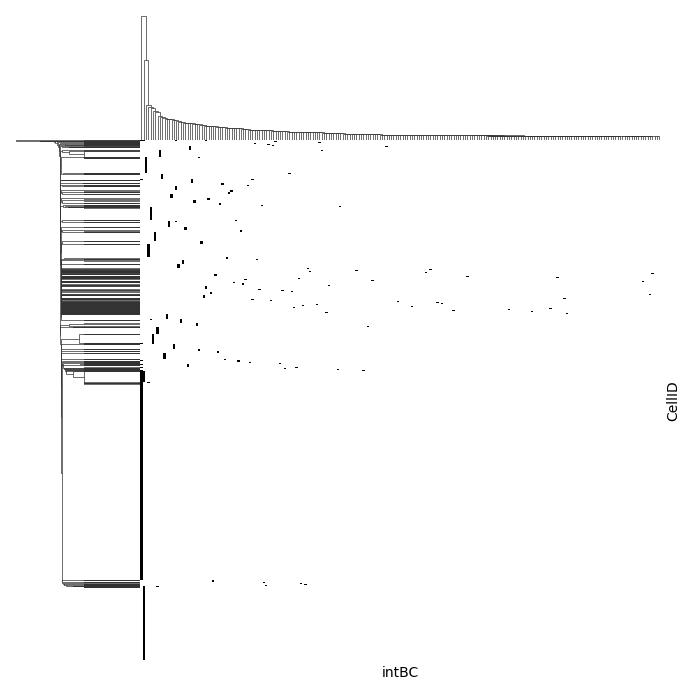

In [113]:
cellBC_staticBC_df = umi_count.pivot(index='CellID',columns='intBC',values='num')

cellBC_staticBC_df = cellBC_staticBC_df.fillna(0)

cellBC_staticBC_df[cellBC_staticBC_df > 0] = 1

import seaborn as sns
ax = sns.clustermap(cellBC_staticBC_df, yticklabels=False,xticklabels=False,cmap='binary',figsize=(7, 7),cbar=False)
ax.cax.set_visible(False)

In [114]:
cellBC_staticBC_df.shape

(5446, 225)

Text(0, 0.5, 'Number of cells')

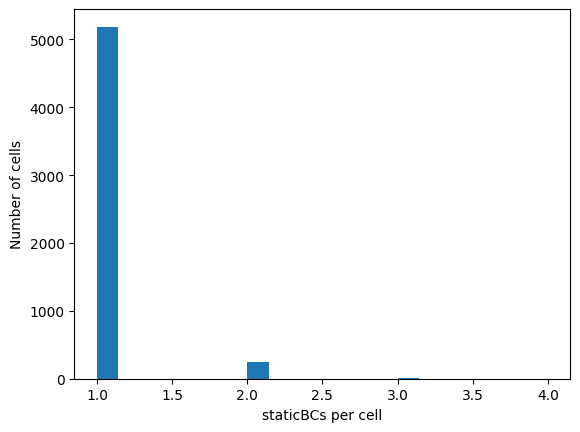

In [115]:
plt.hist(cellBC_staticBC_df.apply(sum,axis=1),bins=21)
plt.xlabel('staticBCs per cell')
plt.ylabel('Number of cells')

## alignment

In [1]:
import pickle as pic
import pandas as pd

In [2]:
with open('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/master_intBCs_filtered.pickle.BLEELE.new','rb')as f:
    master_intBCs_filtered = pic.load(f)

lineageGrp_intBCs = pd.DataFrame([master_intBCs_filtered]).T
lineageGrp_intBCs.columns = ['intBCs']
lineageGrp_intBCs

,intBCs
C1,"[CGGAACCTGAAAAC, GTTTTATCCGCCTG, CCAAATCGGACGT..."
C2,"[CCGTACGCGGCACG, ACACGACAAGAACG, GGCGCGCGTCATA..."
C3,"[AGGGGTGCAAAGCC, GGCCCGGTGCAGAG, GCATAGCCACCTG..."
C4,"[CGGCAAACGGGGGG, TGCTGTGAGCGCGC, AGTGGGGACGTAG..."
C5,"[CAGACCCCAGTCCG, GCCCCTGCCTACAA, GCGAGGGATCCAA..."
...,...
C172,"[GAGAAAGGCTCCGA, TGCGCAAGATAACC, TAATGCCACTTCCG]"
C171,"[ATCACGGCAAAATG, AAGGCGATCCCCGC, CGCCCTTGAGTGG..."
C173,"[TCGGGAGCACCAGG, CGGCCAAGGGAGGC]"
C174,"[TTGAGCCCTCCCTT, GGTGGAGCGAGCCG]"


In [3]:
cell_intBC = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/bin50_staticBC.csv')
cell_intBC

,CellID,intBC,num
0,10000_10050,CCGCCTTGTGAAAG,3
1,10000_10100,AGTGGGGACGTAGG,2
2,10000_10200,GACCAGCACGCGCA,2
3,10000_10200,GACTCCTGGCCGCT,2
4,10000_10250,GCCCCTGCCTACAA,2
...,...,...,...
17484,9950_9200,TCTAGATGAGAAGCG,2
17485,9950_9450,CCGCCTTGTGAAAG,2
17486,9950_9650,CCGCCTTGTGAAAG,3
17487,9950_9850,AGCTTGAATTTCGG,2


In [129]:
'''
cell_lineageGrp = []

for CellID,intBC in zip(cell_intBC.CellID,cell_intBC.intBC):
    for intBCs,lineageGrp in zip(lineageGrp_intBCs.intBCs,lineageGrp_intBCs.index):
        if intBC in intBCs:
            cell_lineageGrp.append([CellID,intBC,lineageGrp[0]])
            continue
            
cell_lineageGrp_df = pd.DataFrame(cell_lineageGrp)
cell_lineageGrp_df.columns = ['CellID','intBC','lineageGrp']
cell_lineageGrp_df = cell_lineageGrp_df.drop_duplicates(subset=['CellID','lineageGrp'],keep='first')
cell_lineageGrp_df
cell_lineageGrp_df.to_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/spatial_cell_lineage.csv',index=False)
'''

"\ncell_lineageGrp = []\n\nfor CellID,intBC in zip(cell_intBC.CellID,cell_intBC.intBC):\n    for intBCs,lineageGrp in zip(lineageGrp_intBCs.intBCs,lineageGrp_intBCs.index):\n        if intBC in intBCs:\n            cell_lineageGrp.append([CellID,intBC,lineageGrp[0]])\n            continue\n            \ncell_lineageGrp_df = pd.DataFrame(cell_lineageGrp)\ncell_lineageGrp_df.columns = ['CellID','intBC','lineageGrp']\ncell_lineageGrp_df = cell_lineageGrp_df.drop_duplicates(subset=['CellID','lineageGrp'],keep='first')\ncell_lineageGrp_df\ncell_lineageGrp_df.to_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/spatial_cell_lineage.csv',index=False)\n"

In [4]:
cell_lineageGrp = []

for CellID,intBC in zip(cell_intBC.CellID,cell_intBC.intBC):
    for intBCs,lineageGrp in zip(lineageGrp_intBCs.intBCs,lineageGrp_intBCs.index):
        if intBC in intBCs:
            cell_lineageGrp.append([CellID,intBC,lineageGrp])
            continue

cell_lineageGrp_df = pd.DataFrame(cell_lineageGrp)
cell_lineageGrp_df.columns = ['CellID','intBC','lineageGrp']
cell_lineageGrp_df_weight = pd.merge(cell_intBC,cell_lineageGrp_df,on=['CellID','intBC'],how='inner')
#cell_lineageGrp_df_weight = cell_lineageGrp_df_weight.drop_duplicates(subset=['CellID','num'],keep=False)
cell_lineageGrp_df_weight = cell_lineageGrp_df_weight.groupby(['CellID','lineageGrp'])['num'].sum().reset_index()
cell_lineageGrp_df_weight = cell_lineageGrp_df_weight.sort_values(['num'],ascending=False)
cell_lineageGrp_df_weight = cell_lineageGrp_df_weight.drop_duplicates(subset=['CellID'],keep='first')
cell_lineageGrp_df_weight.index = cell_lineageGrp_df_weight.CellID.astype('str')
#cell_lineageGrp_df_weight

In [5]:
len(set(cell_lineageGrp_df_weight['CellID']))

12749

In [6]:
cell_lineageGrp_df_weight['x'] = [ int(cell.split('_')[0]) for cell in cell_lineageGrp_df_weight['CellID']]
cell_lineageGrp_df_weight['y'] = [ int(cell.split('_')[1]) for cell in cell_lineageGrp_df_weight['CellID']]

In [133]:
cell_lineageGrp_df_weight.to_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/spatial_cell_lineage_new.csv',index=False)

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

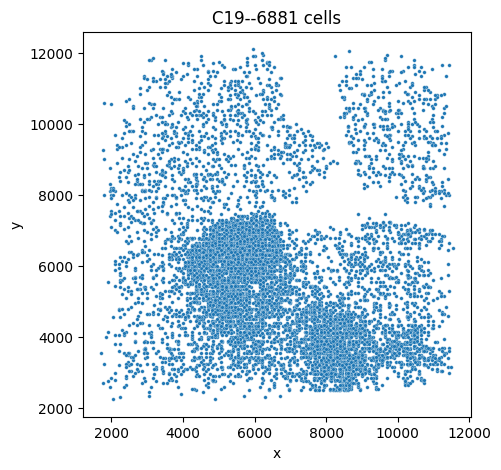

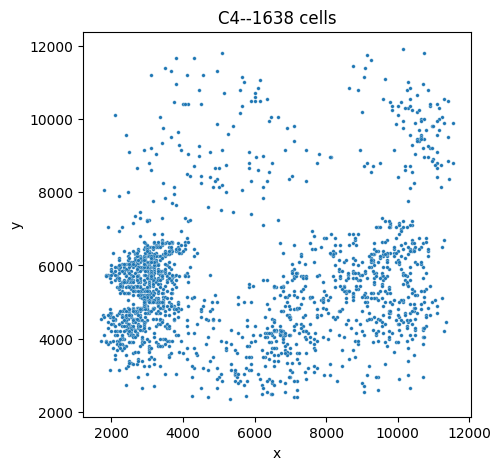

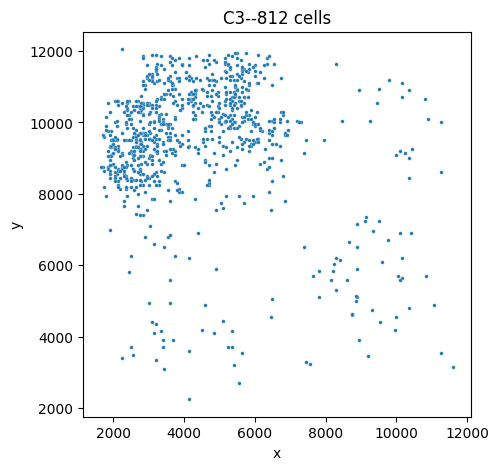

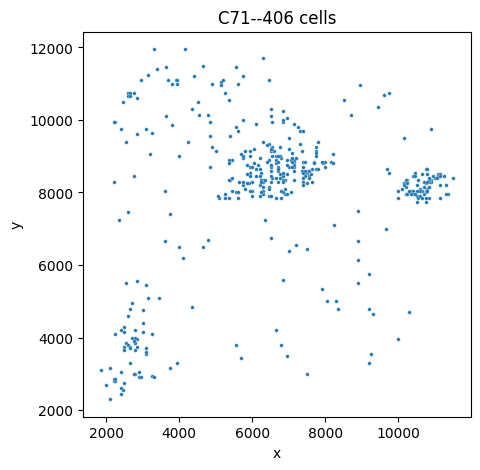

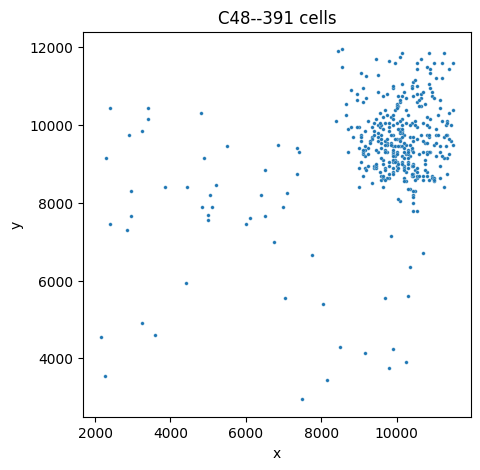

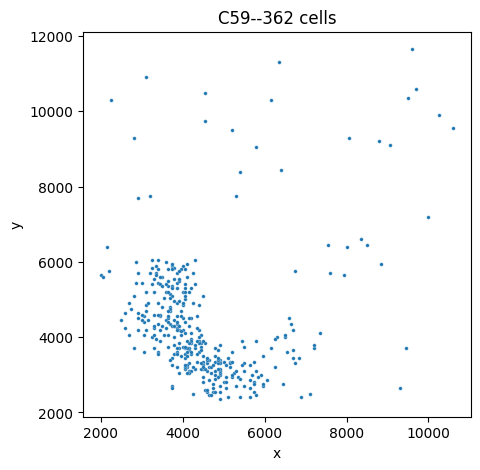

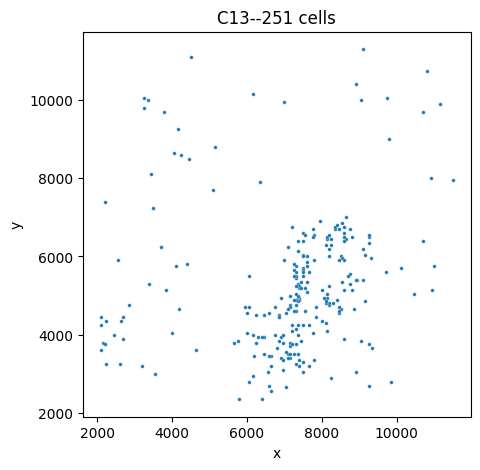

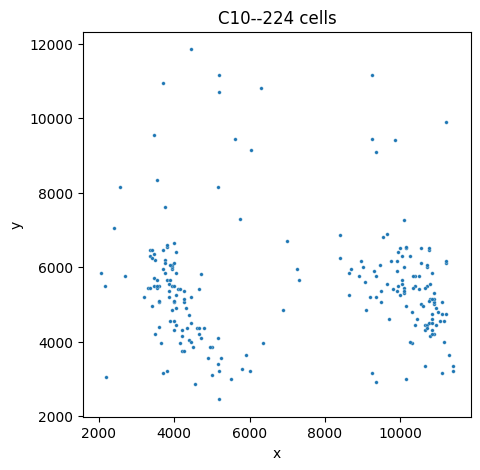

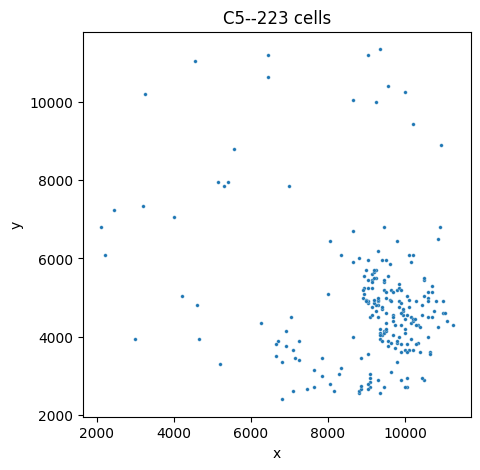

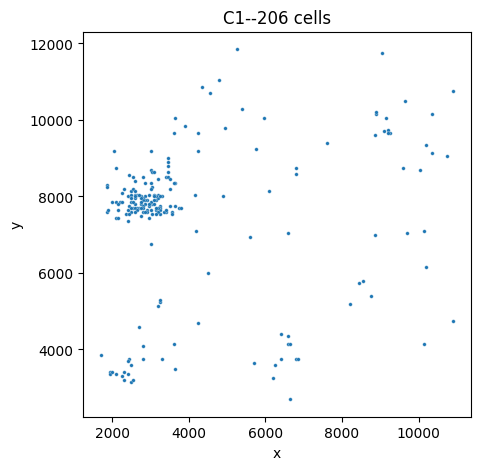

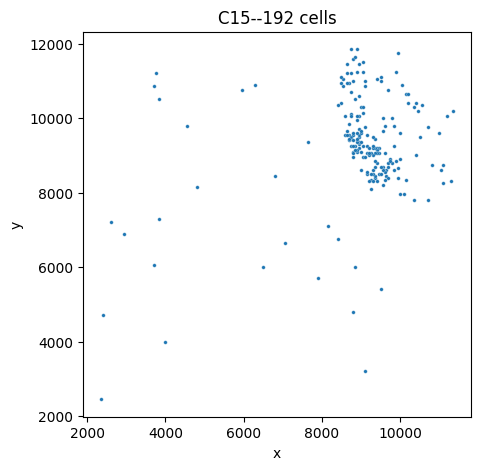

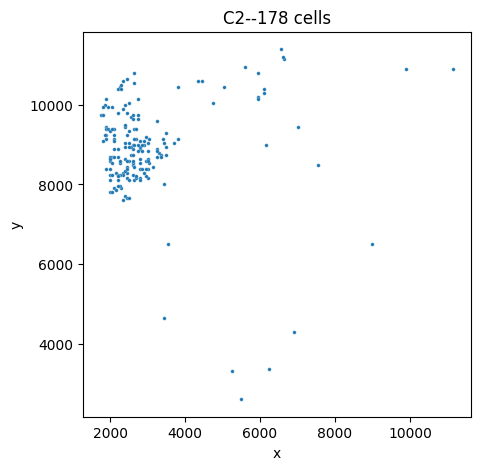

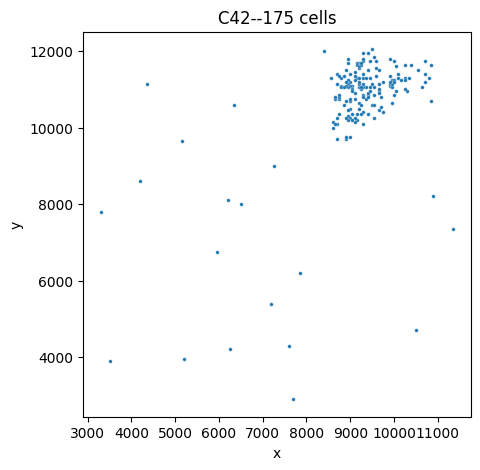

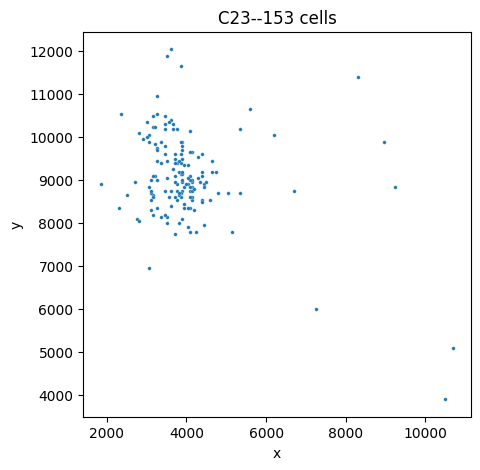

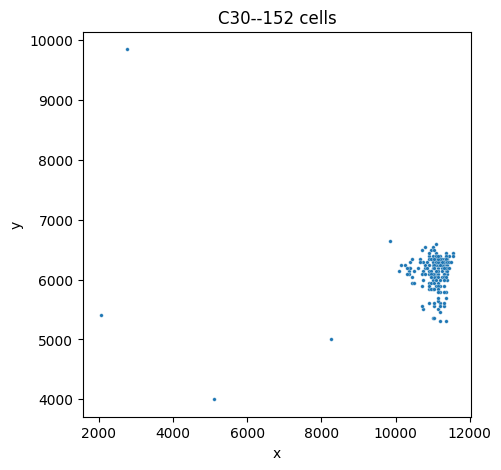

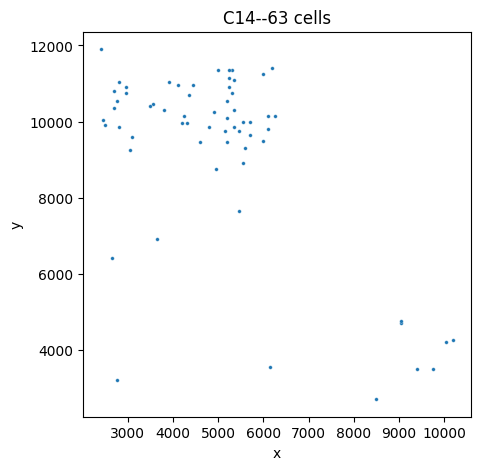

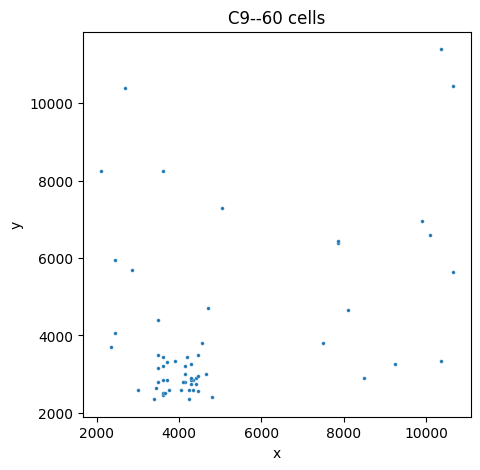

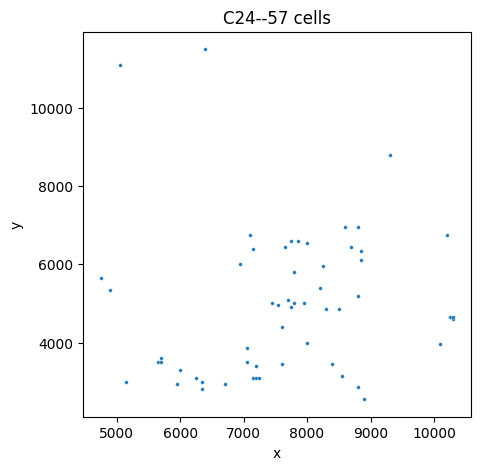

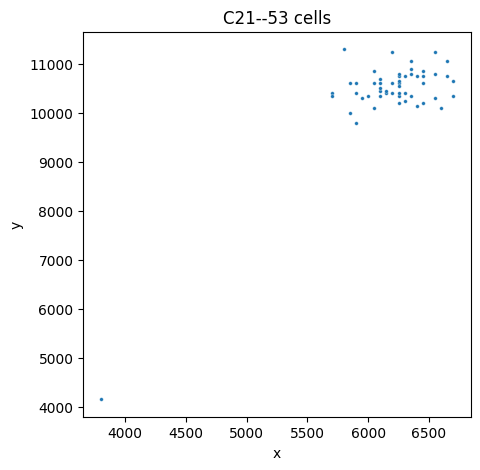

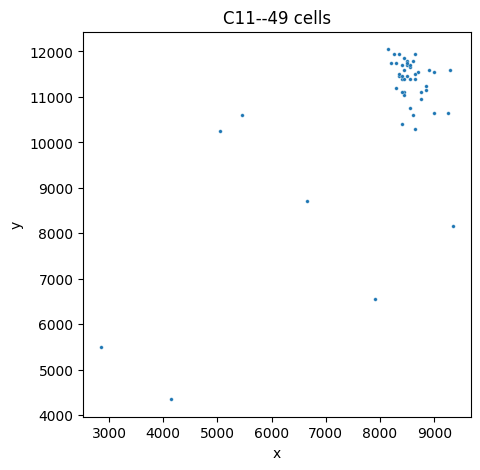

In [9]:
for clone in cell_lineageGrp_df_weight['lineageGrp'].value_counts().index[0:20]:
    spatial_lineageGrp_sub = cell_lineageGrp_df_weight[cell_lineageGrp_df_weight['lineageGrp']==clone]
    plt.figure(figsize=(5, 5))
    sns.scatterplot(data=spatial_lineageGrp_sub,x='x',y='y',s=7).set(title=str(clone)+'--'+str(spatial_lineageGrp_sub.shape[0])+' cells')
    plt.show()

In [2]:
12749/17489

0.7289724969981131

# Target site analysis

In [1]:
import cassiopeia as cas
import os
import cassiopeia
import gzip
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.stats import entropy
import scanpy as sc

## load cell-intBC-UMI table 

In [2]:
gene_names = ['Calr', 'Myl6', 'Calm2', 'Rpl39', 'Cfl1', 'Acta1', 'Hsp90b1', 'Calm1', 'Hint1', 'Btf3', 'Lgals1', 'Slc25a3', 'Tpt1', 'Hsp90ab1', 'Fth1']

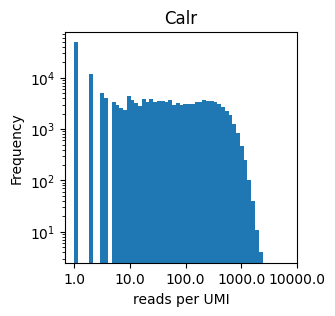

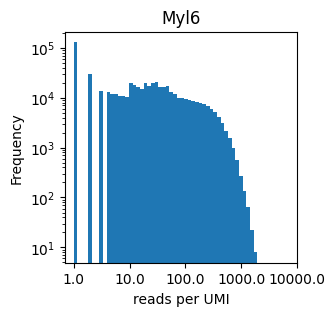

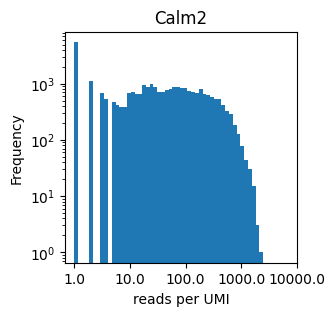

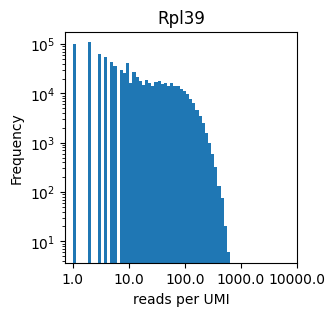

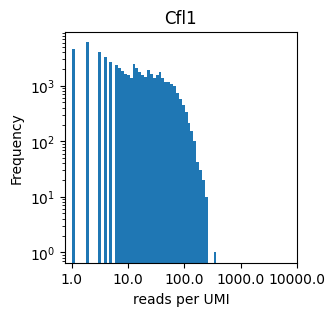

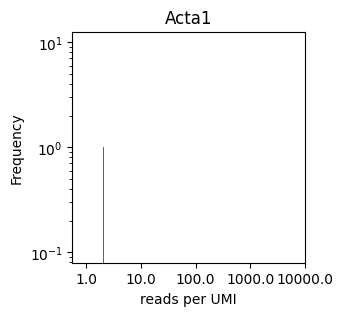

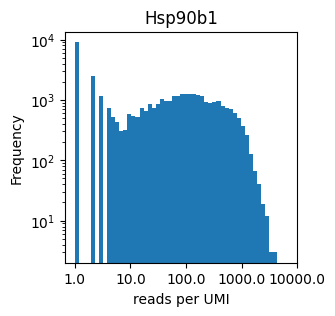

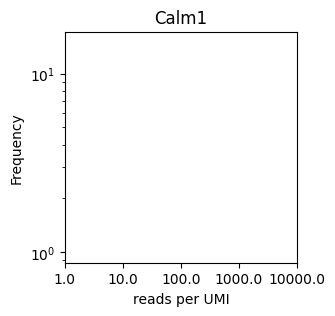

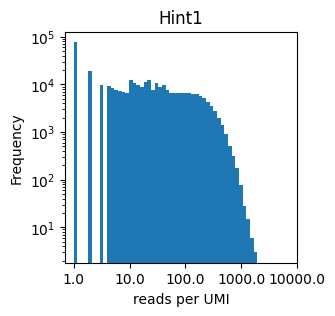

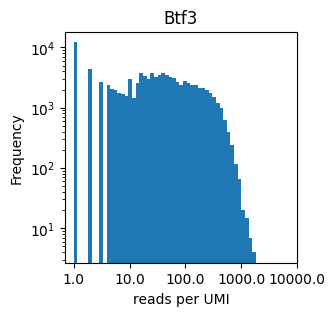

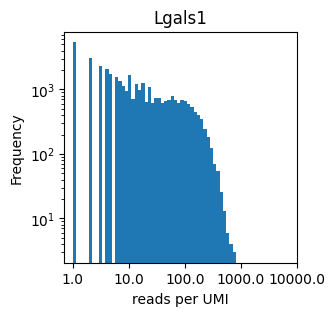

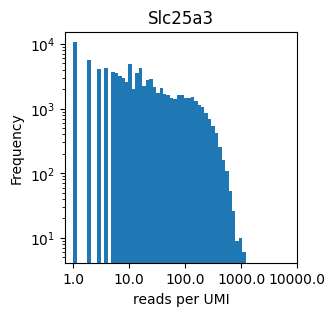

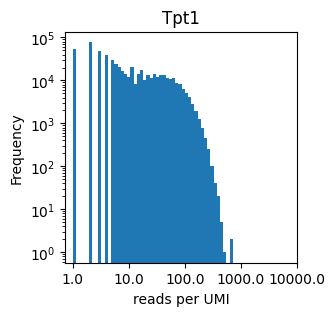

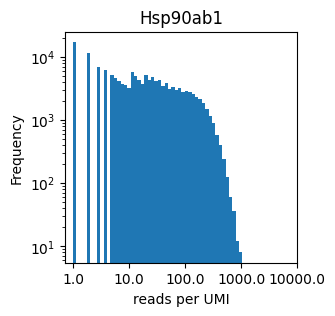

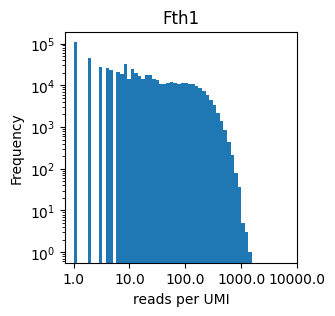

In [3]:
umi_table_all = []

for gene in gene_names:
        umi_table = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/cassiopeia_result/'+gene+'/'+'umi_table_filtered.csv',
                               sep=',',index_col=0,header=0,keep_default_na=False)
        
        plt.figure(figsize=(3,3))
        plt.hist(np.log(umi_table['readCount'])/np.log(10), bins=50)
        plt.xticks(range(5),np.logspace(0,4,5))
        plt.yscale('log')
        plt.title(gene)
        plt.xlabel('reads per UMI')
        plt.ylabel('Frequency')
        plt.show()
        
        umi_table_all.append(umi_table)
umi_table_df = pd.concat(umi_table_all)


In [4]:
umi_table_df

,readName,AlignmentScore,CIGAR,Mismatch,Mismatch_num,QueryBegin,Ref,ReferenceBegin,Seq,UMI,allele,cellBC,indel_length,indel_num,intBC,length_M,r1,readCount,reads_indel_length,reads_indel_num
0,AAAAAAAACCCCTTATGATGCGTTA_CCCTTTCCTC_6,690,80M2D64M,"[[86, 'C>G']]",1,6,GAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGAATGGGG...,0,AATCCGGAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGA...,CCCTTTCCTC,81:2D,AAAAAAAACCCCTTATGATGCGTTA,2,1,Calr,144,81:2D,6,2,1
1,AAAAAAACCAGCGTCTGAAAAAATA_ACTTGGCACA_327,720,144M,[],0,6,GAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGAATGGGG...,0,AATCCGGAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGA...,ACTTGGCACA,None,AAAAAAACCAGCGTCTGAAAAAATA,0,0,Calr,144,None,327,0,0
2,AAAAAAACCGCGCTGATTCGAGCCC_CCGCGTCCCA_13,510,82M56D35M,[],0,6,GAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGAATGGGG...,0,AATCCGGAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGA...,CCGCGTCCCA,83:56D,AAAAAAACCGCGCTGATTCGAGCCC,56,1,Calr,117,83:56D,13,56,1
3,AAAAAAAGATGCCTCCGACACCTGT_CCTGCCCCGT_132,621,65M40D71M,[],0,6,GAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGAATGGGG...,0,AATCCGGAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGA...,CCTGCCCCGT,66:40D,AAAAAAAGATGCCTCCGACACCTGT,40,1,Calr,136,66:40D,132,40,1
4,AAAAAAAGGCGGACAGGATTAATCT_TGTGGAGCTG_38,695,79M6D65M,[],0,6,GAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGAATGGGG...,0,AATCCGGAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGA...,TGTGGAGCTG,80:6D,AAAAAAAGGCGGACAGGATTAATCT,6,1,Calr,144,80:6D,38,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612822,TTTTTTTTGGCCTGAAGTCCTTATT_AGGAGTGTAA_1,720,144M,[],0,6,GACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCACGTGACT...,0,ACTTGAGACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCAC...,AGGAGTGTAA,None,TTTTTTTTGGCCTGAAGTCCTTATT,0,0,Fth1,144,None,1,0,0
612823,TTTTTTTTGTCTTGTTTCTCCCACG_TAGGAACACT_1,572,60M40D68M,"[[146, 'C>A']]",1,6,GACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCACGTGACT...,0,ACTTGAGACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCAC...,TAGGAACACT,61:40D,TTTTTTTTGTCTTGTTTCTCCCACG,40,1,Fth1,128,61:40D,1,40,1
612824,TTTTTTTTGTCTTGTTTCTCCCACG_TAGGCACACT_36,699,90M2D54M,[],0,6,GACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCACGTGACT...,0,ACTTGAGACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCAC...,TAGGCACACT,91:2D,TTTTTTTTGTCTTGTTTCTCCCACG,2,1,Fth1,144,91:2D,36,2,1
612825,TTTTTTTTTAGTGACCTTGGCTCGG_CAAATCTCGT_7,720,144M,[],0,6,GACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCACGTGACT...,0,ACTTGAGACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCAC...,CAAATCTCGT,None,TTTTTTTTTAGTGACCTTGGCTCGG,0,0,Fth1,144,None,7,0,0


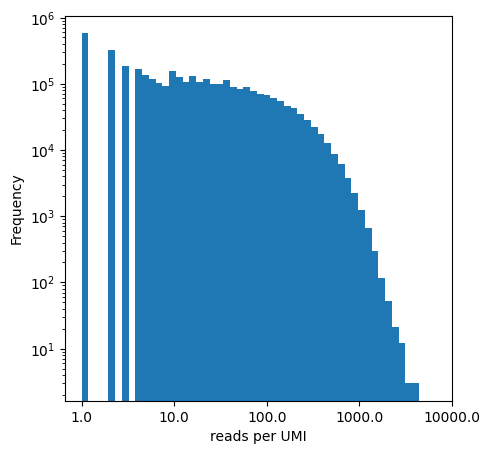

In [5]:
plt.figure(figsize=(5,5))
plt.hist(np.log(umi_table_df['readCount'])/np.log(10), bins=50)
plt.xticks(range(5),np.logspace(0,4,5))
plt.yscale('log')
plt.xlabel('reads per UMI')
plt.ylabel('Frequency')
plt.show()

## filter UMI

In [6]:
umi_table = umi_table_df.sort_values(by='readCount',ascending=False).groupby(['cellBC','UMI']).head(1)
umi_table = umi_table[umi_table['indel_length'] < 50]
umi_table = umi_table[umi_table['length_M'] > 90]
umi_table = umi_table[umi_table['Mismatch_num'] < 15 ]
umi_table = umi_table[umi_table['readCount'] >= 3 ] # defult 3

In [7]:
umi_table 

,readName,AlignmentScore,CIGAR,Mismatch,Mismatch_num,QueryBegin,Ref,ReferenceBegin,Seq,UMI,allele,cellBC,indel_length,indel_num,intBC,length_M,r1,readCount,reads_indel_length,reads_indel_num
1158,AACTGTGTTCACACGACAGATTCGC_CGACCGTACG_4379,690,89M11D55M,[],0,6,AGGGACAGAAGAAGAAGAGGAGGAAACAGAAAAGGAATCTACAGAG...,0,ATAGCGAGGGACAGAAGAAGAAGAGGAGGAAACAGAAAAGGAATCT...,CGACCGTACG,90:11D,AACTGTGTTCACACGACAGATTCGC,11,1,Hsp90b1,144,90:11D,4379,11,1
3803,ACCCTAACACGAGATCCCGTTGACG_TCCCTGCCCA_4297,720,144M,[],0,6,AGGGACAGAAGAAGAAGAGGAGGAAACAGAAAAGGAATCTACAGAG...,0,ATAGCGAGGGACAGAAGAAGAAGAGGAGGAAACAGAAAAGGAATCT...,TCCCTGCCCA,None,ACCCTAACACGAGATCCCGTTGACG,0,0,Hsp90b1,144,None,4297,0,0
26080,GCCTAACCCTAGGCCTTAGGACAAG_ACTTATCTCC_3845,686,87M15D57M,[],0,6,AGGGACAGAAGAAGAAGAGGAGGAAACAGAAAAGGAATCTACAGAG...,0,ATAGCGAGGGACAGAAGAAGAAGAGGAGGAAACAGAAAAGGAATCT...,ACTTATCTCC,88:15D,GCCTAACCCTAGGCCTTAGGACAAG,15,1,Hsp90b1,144,88:15D,3845,15,1
7415,AGCTTAACTCTTCAGATTCGTACAC_CTTGCCTCCC_3664,720,144M,[],0,6,AGGGACAGAAGAAGAAGAGGAGGAAACAGAAAAGGAATCTACAGAG...,0,ATAGCGAGGGACAGAAGAAGAAGAGGAGGAAACAGAAAAGGAATCT...,CTTGCCTCCC,None,AGCTTAACTCTTCAGATTCGTACAC,0,0,Hsp90b1,144,None,3664,0,0
14794,CCCAGCTGGTTAAGCGCCGTTCCCA_CCAGCTTTAT_3579,720,144M,[],0,6,AGGGACAGAAGAAGAAGAGGAGGAAACAGAAAAGGAATCTACAGAG...,0,ATAGCGAGGGACAGAAGAAGAAGAGGAGGAAACAGAAAAGGAATCT...,CCAGCTTTAT,None,CCCAGCTGGTTAAGCGCCGTTCCCA,0,0,Hsp90b1,144,None,3579,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85863,TTCCGACTGCCATCCGCCACTAATA_GCAGAACAGC_3,699,88M2D56M,[],0,6,CATGGACTGAATCTGCTTGTTGATCAGTGTTGAAAGTGCAAAGGAA...,0,ATCCAGCATGGACTGAATCTGCTTGTTGATCAGTGTTGAAAGTGCA...,GCAGAACAGC,89:2D,TTCCGACTGCCATCCGCCACTAATA,2,1,Slc25a3,144,89:2D,3,2,1
140274,ATGGTTCGGTGGCAAGAGGGCGGGT_CCCTGGCCCG_3,664,144M,[],0,6,CATAATTGGCTGCTGCTTACCATCCATACAACACCAGGACTTAGGA...,0,ACAGTGCATAATTGGCTGCTGCTTACCATCCATACAACACCAGGAC...,CCCTGGCCCG,None,ATGGTTCGGTGGCAAGAGGGCGGGT,0,0,Tpt1,144,None,3,0,0
32477,CCCTATACAACCTGGCGTACTCCCC_TGCCCTTGTT_3,720,144M,[],0,6,CATGGACTGAATCTGCTTGTTGATCAGTGTTGAAAGTGCAAAGGAA...,0,ATCCAGCATGGACTGAATCTGCTTGTTGATCAGTGTTGAAAGTGCA...,TGCCCTTGTT,None,CCCTATACAACCTGGCGTACTCCCC,0,0,Slc25a3,144,None,3,0,0
333386,GATCCCGGTACTGCCTTCAACTTAT_GCCCAGATCT_3,664,144M,[],0,6,CATAATTGGCTGCTGCTTACCATCCATACAACACCAGGACTTAGGA...,0,ACAGTGCATAATTGGCTGCTGCTTACCATCCATACAACACCAGGAC...,GCCCAGATCT,None,GATCCCGGTACTGCCTTCAACTTAT,0,0,Tpt1,144,None,3,0,0


In [8]:
gene_names=['Calr', 'Myl6', 'Calm2', 'Rpl39', 'Cfl1', 'Acta1', 'Hsp90b1', 'Calm1', 
            'Hint1', 'Btf3', 'Lgals1', 'Slc25a3', 'Tpt1', 'Hsp90ab1', 'Fth1']
cut_sites = [80,91,93,87,63,89,89,84,86,94,48,87,89,85,89]
wc = [-17,-3,-3,-17,-3,-17,-3,-17,-3,-17,-17,-17,-17,-3,-17]

intBC_cutSite = pd.concat([pd.DataFrame(data=gene_names,columns=['intBC']),pd.DataFrame(data=cut_sites,columns=['cut_site']),
                          pd.DataFrame(data=wc,columns=['wc'])],axis=1)

In [9]:
umi_table = pd.merge(intBC_cutSite,umi_table,how='inner',on=['intBC'])

In [10]:
## constrain cut site in 30bp the left and right of the cutsite location

def filter_based_on_region(edit):
    cut_site = edit[0]
    mark = np.zeros(200)
    r1 = edit[1]
    #print(edit)
    if 'None' in r1:
        return 'passed'
    indels = re.findall(r'(\d+)([MIDNSHP=X])', r1)
    positions = re.findall(r'(\d+)(:)', r1)
    for indel, position in zip(indels,positions):
        #print(position)
        pos = int(position[0])
        if abs(pos-cut_site)<=12: 
            count = int(indel[0])
            mark[pos:pos+count] = 1
        else:
            return 'failed'

    min_pos = np.where(mark==1)[0][0]
    max_pos = np.where(mark==1)[0][-1]
    cut_min = cut_site - 30
    cut_max = cut_site + 30

    if cut_min > min_pos or cut_max < max_pos:
        return 'failed'
    else:
        return 'passed'
    


In [11]:
umi_table['r1_isvalid'] = umi_table[['cut_site','r1']].apply(filter_based_on_region,axis=1)
umi_table = umi_table[umi_table['r1_isvalid']=='passed']

In [12]:
umi_table

,intBC,cut_site,wc,readName,AlignmentScore,CIGAR,Mismatch,Mismatch_num,QueryBegin,Ref,...,allele,cellBC,indel_length,indel_num,length_M,r1,readCount,reads_indel_length,reads_indel_num,r1_isvalid
0,Calr,80,-17,CCACAGTCCTTAGCTTCGTTGAATT_TTGAAAAAGG_2238,690,77M11D67M,[],0,6,GAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGAATGGGG...,...,78:11D,CCACAGTCCTTAGCTTCGTTGAATT,11,1,144,78:11D,2238,11,1,passed
1,Calr,80,-17,ATAGATCCCAGTTATGCTTCCCCTA_CTGTGCCCTG_2184,720,144M,[],0,6,GAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGAATGGGG...,...,None,ATAGATCCCAGTTATGCTTCCCCTA,0,0,144,None,2184,0,0,passed
2,Calr,80,-17,TTTCCCCACGCGGGGCGGAATAAGA_AAGCGAGATT_2071,720,144M,[],0,6,GAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGAATGGGG...,...,None,TTTCCCCACGCGGGGCGGAATAAGA,0,0,144,None,2071,0,0,passed
3,Calr,80,-17,ATGCAAGAATCAATATCGCGCGGGA_GCAAGCAGAA_1982,720,144M,[],0,6,GAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGAATGGGG...,...,None,ATGCAAGAATCAATATCGCGCGGGA,0,0,144,None,1982,0,0,passed
4,Calr,80,-17,CTTGCCAAAGCCATGCACGAGCCTC_GAGCTGACGA_1922,672,73M29D71M,[],0,6,GAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGAATGGGG...,...,74:29D,CTTGCCAAAGCCATGCACGAGCCTC,29,1,144,74:29D,1922,29,1,passed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2600336,Fth1,89,-17,AGGTCTACGCAGCGAATTGTGTTTC_GCAAACAGCT_3,720,144M,[],0,6,GACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCACGTGACT...,...,None,AGGTCTACGCAGCGAATTGTGTTTC,0,0,144,None,3,0,0,passed
2600337,Fth1,89,-17,AGGTCGTTTGGGTACGAGTATGCGA_GTTTTCACTT_3,720,144M,[],0,6,GACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCACGTGACT...,...,None,AGGTCGTTTGGGTACGAGTATGCGA,0,0,144,None,3,0,0,passed
2600338,Fth1,89,-17,AGGTCTGATACAGTTCCCATGAGGA_ATCGGTCTCT_3,668,89M24D55M,"[[88, 'C>T']]",1,6,GACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCACGTGACT...,...,90:24D,AGGTCTGATACAGTTCCCATGAGGA,24,1,144,90:24D,3,24,1,passed
2600339,Fth1,89,-17,AGGTCTCTGCGCCACGTGTTTTTAT_TGGAATCGTT_3,720,144M,[],0,6,GACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCACGTGACT...,...,None,AGGTCTCTGCGCCACGTGTTTTTAT,0,0,144,None,3,0,0,passed


In [13]:
barcodeToPos_df = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/barcodeToPos.txt',sep='\t',header=None)
barcodeToPos_df.columns = ['CID','x','y']
barcodeToPos_df['x_y'] = barcodeToPos_df['x'].astype('str') + '_' + barcodeToPos_df['y'].astype('str')
barcodeToPos_dict = barcodeToPos_df.set_index('CID')['x_y'].to_dict()

In [14]:
umi_table['x_y'] = [ barcodeToPos_dict[CID] for CID in umi_table['cellBC'] ]

In [15]:
gem = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/SPATIAL/T2/B03203C612.tissue.bin50.gem',
            sep='\t',header=0)
gem.columns = ['geneID','x','y','MIDCount','ExonCount','bin50_x','bin50_y','CellID']
gem['CellID'] = gem['CellID'].astype('str')
gem['x_y'] = gem['x'].astype('str') + '_' + gem['y'].astype('str')
gem = gem.drop_duplicates(subset='x_y',keep='first')

In [16]:
umi_table = pd.merge(umi_table,gem,on='x_y',how='left')
umi_table = umi_table.dropna(axis=0,subset = ['CellID']) 

In [17]:
umi_table

,intBC,cut_site,wc,readName,AlignmentScore,CIGAR,Mismatch,Mismatch_num,QueryBegin,Ref,...,r1_isvalid,x_y,geneID,x,y,MIDCount,ExonCount,bin50_x,bin50_y,CellID
0,Calr,80,-17,CCACAGTCCTTAGCTTCGTTGAATT_TTGAAAAAGG_2238,690,77M11D67M,[],0,6,GAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGAATGGGG...,...,passed,6427_11487,Calr,6427.0,11487.0,3.0,3.0,6400.0,11450.0,6400_11450
1,Calr,80,-17,ATAGATCCCAGTTATGCTTCCCCTA_CTGTGCCCTG_2184,720,144M,[],0,6,GAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGAATGGGG...,...,passed,7323_9699,Calr,7323.0,9699.0,4.0,4.0,7300.0,9650.0,7300_9650
2,Calr,80,-17,TTTCCCCACGCGGGGCGGAATAAGA_AAGCGAGATT_2071,720,144M,[],0,6,GAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGAATGGGG...,...,passed,4987_6376,Calr,4987.0,6376.0,2.0,2.0,4950.0,6350.0,4950_6350
3,Calr,80,-17,ATGCAAGAATCAATATCGCGCGGGA_GCAAGCAGAA_1982,720,144M,[],0,6,GAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGAATGGGG...,...,passed,9018_6144,Calr,9018.0,6144.0,1.0,1.0,9000.0,6100.0,9000_6100
4,Calr,80,-17,CTTGCCAAAGCCATGCACGAGCCTC_GAGCTGACGA_1922,672,73M29D71M,[],0,6,GAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGAATGGGG...,...,passed,6496_6107,Calr,6496.0,6107.0,1.0,1.0,6450.0,6100.0,6450_6100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496256,Fth1,89,-17,AGGTCTACGCAGCGAATTGTGTTTC_GCAAACAGCT_3,720,144M,[],0,6,GACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCACGTGACT...,...,passed,7576_2768,Rpl28,7576.0,2768.0,2.0,2.0,7550.0,2750.0,7550_2750
2496257,Fth1,89,-17,AGGTCGTTTGGGTACGAGTATGCGA_GTTTTCACTT_3,720,144M,[],0,6,GACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCACGTGACT...,...,passed,8711_3161,Cdadc1,8711.0,3161.0,1.0,1.0,8700.0,3150.0,8700_3150
2496258,Fth1,89,-17,AGGTCTGATACAGTTCCCATGAGGA_ATCGGTCTCT_3,668,89M24D55M,"[[88, 'C>T']]",1,6,GACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCACGTGACT...,...,passed,5814_9018,Rpl39,5814.0,9018.0,3.0,3.0,5800.0,9000.0,5800_9000
2496259,Fth1,89,-17,AGGTCTCTGCGCCACGTGTTTTTAT_TGGAATCGTT_3,720,144M,[],0,6,GACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCACGTGACT...,...,passed,3209_7669,Afap1,3209.0,7669.0,1.0,1.0,3200.0,7650.0,3200_7650


In [18]:
allele_table = (
    umi_table.groupby(["CellID", "intBC", "r1",'allele'])
    .agg({"readCount": "sum", "UMI": "count"})
    .reset_index()
    .sort_values(["UMI", "readCount"], ascending=False)
)


allele_table['UMI_ratio'] = allele_table['UMI'] / allele_table.groupby(["CellID", "intBC"])['UMI'].transform('sum')
allele_table = allele_table[allele_table['UMI'] >= 2]

In [19]:
allele_table

,CellID,intBC,r1,allele,readCount,UMI,UMI_ratio
252032,3350_9100,Fth1,None,None,7773,103,0.990385
257209,3400_9100,Fth1,None,None,5370,73,0.924051
257237,3400_9150,Fth1,None,None,5107,66,0.929577
222986,3050_9600,Fth1,None,None,4829,50,0.892857
194069,2750_9150,Fth1,None,None,4069,50,0.925926
...,...,...,...,...,...,...,...
777211,9800_11150,Cfl1,None,None,6,2,1.000000
777626,9800_2750,Rpl39,88:2D,88:2D,6,2,0.181818
780265,9800_9400,Hsp90ab1,None,None,6,2,0.400000
787219,9900_7000,Rpl39,88:2D,88:2D,6,2,0.111111


In [20]:
len(set(allele_table['CellID']))

34894

In [21]:
allele_table.to_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/allele_table.csv',index=False)

In [77]:
def edit_matrix_make(gene_edit_info):
    gene_edit_info.index = range(0,gene_edit_info.shape[0])
    edit_matrix = np.zeros([gene_edit_info.shape[0],150])

    for i in range(0,gene_edit_info.shape[0]):
        allele = gene_edit_info['r1'][i]
        
        if allele == 'None':
            edit_matrix[i,:] = 2
            continue
        
        indels = re.findall(r'(\d+)([MIDNSHP=X])', allele)
        positions = re.findall(r'(\d+)(:)', allele)
        for indel, pos in zip(indels,positions):
            #print(pos)
            count = int(indel[0])
            pos = int(pos[0])
            if indel[1] == 'I':    
                if pos-1+count < 150:
                    edit_matrix[i,pos-1:pos-1+count] = 1
            if indel[1] == 'D':
                if pos-1+count < 150:
                    edit_matrix[i,pos-1:pos-1+count] = -1

#如果编辑区在cut site 左右5bp内 remove this indel
    return edit_matrix

/tmp/ipykernel_40589/3803599367.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_edit_info['num'] = 1


<Figure size 600x600 with 0 Axes>

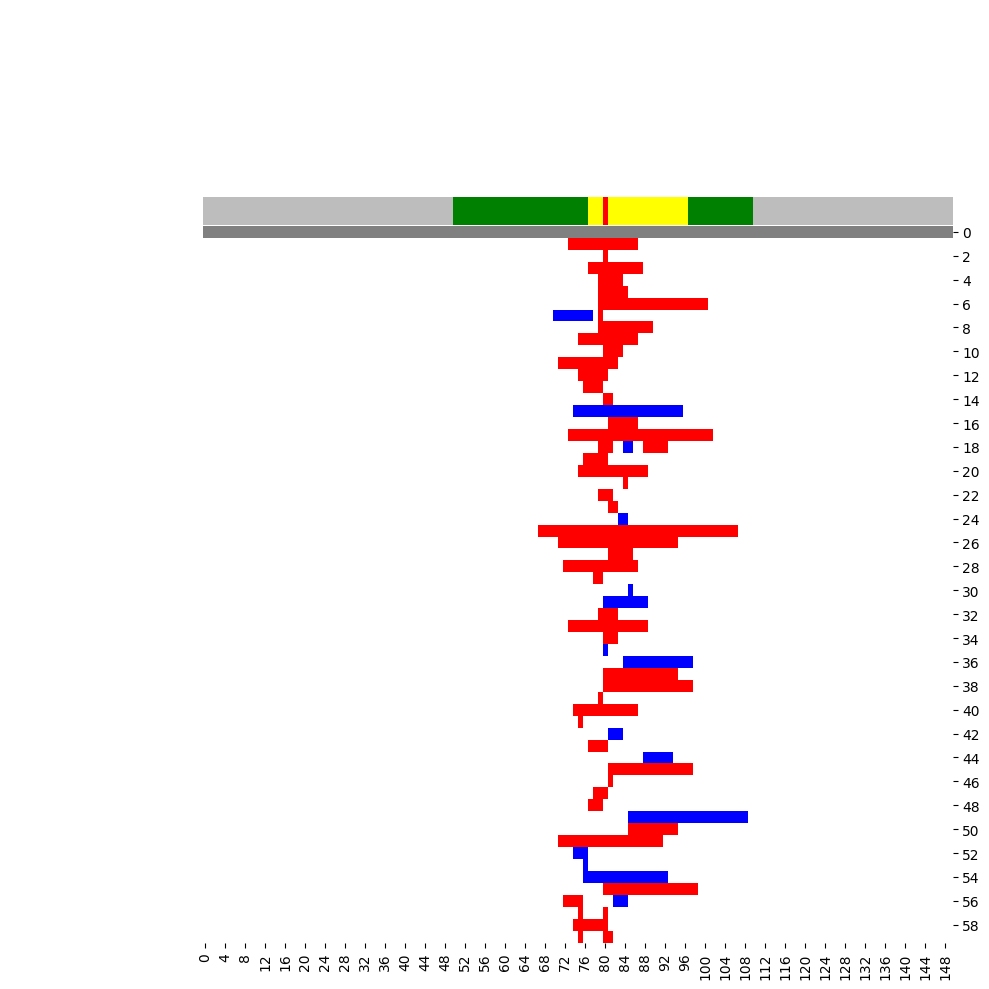

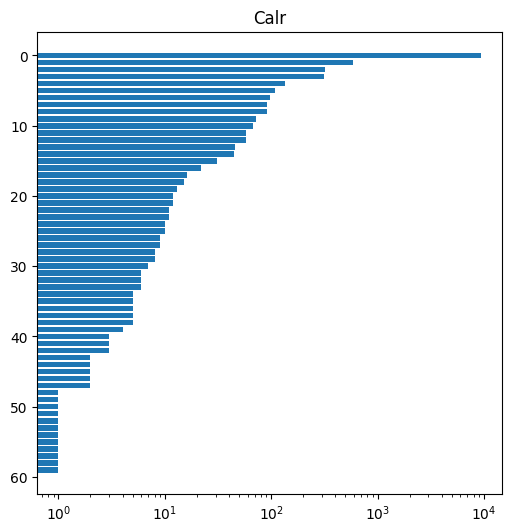

/tmp/ipykernel_40589/3803599367.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_edit_info['num'] = 1


<Figure size 600x600 with 0 Axes>

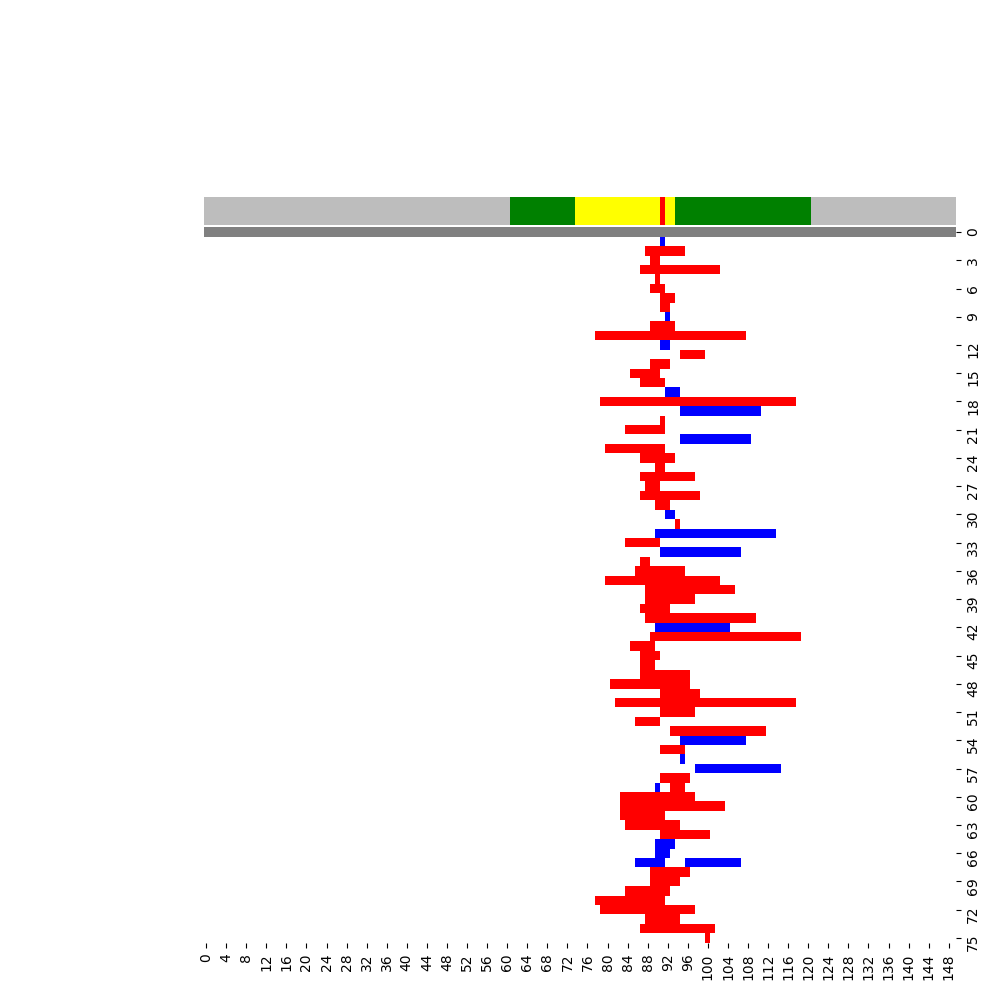

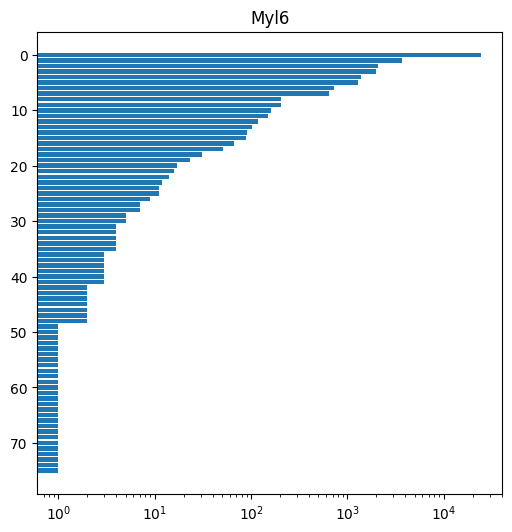

/tmp/ipykernel_40589/3803599367.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_edit_info['num'] = 1


<Figure size 600x600 with 0 Axes>

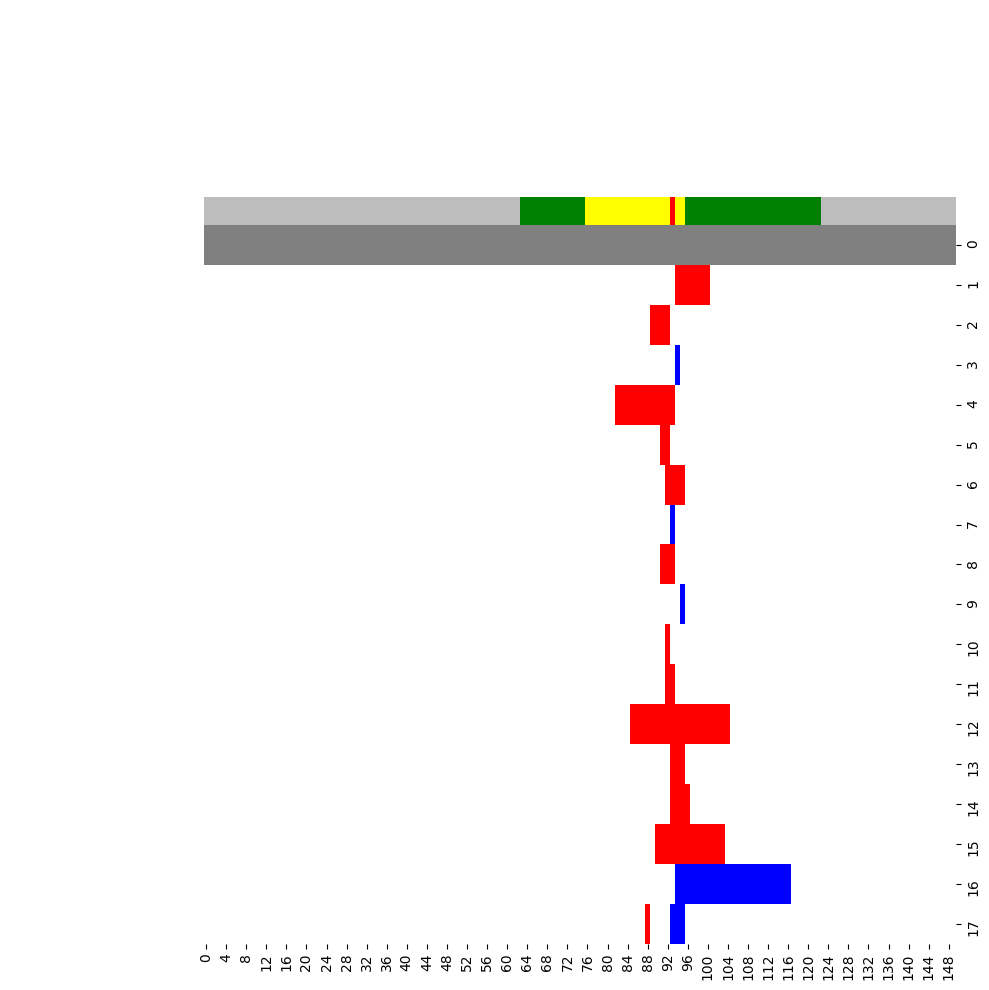

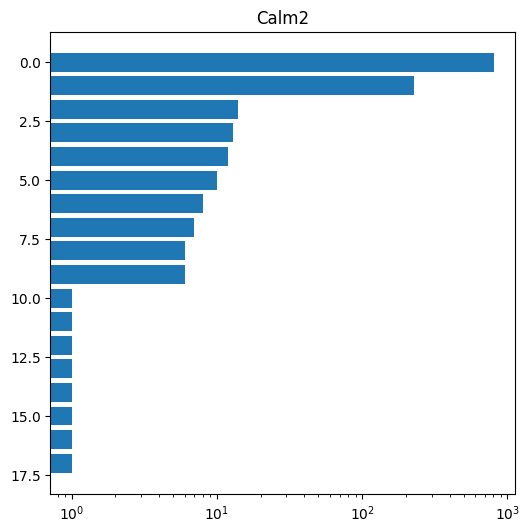

/tmp/ipykernel_40589/3803599367.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_edit_info['num'] = 1


<Figure size 600x600 with 0 Axes>

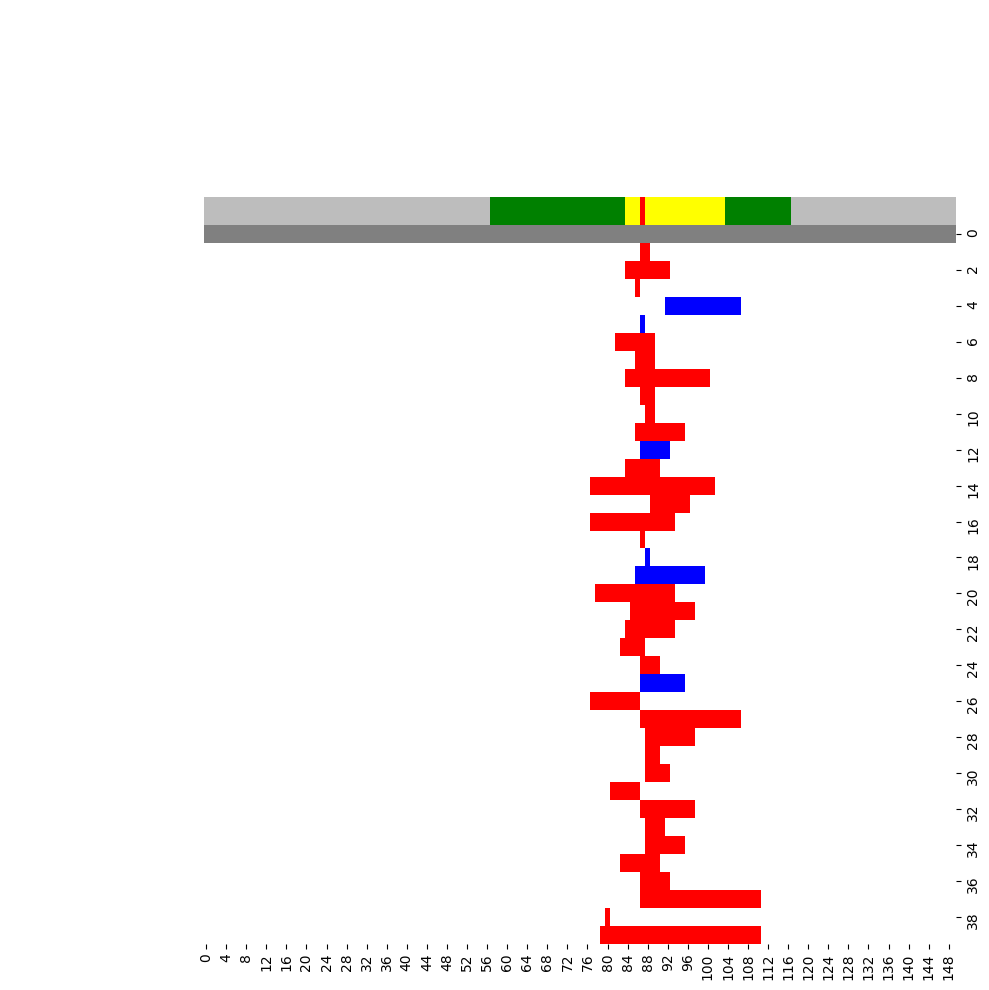

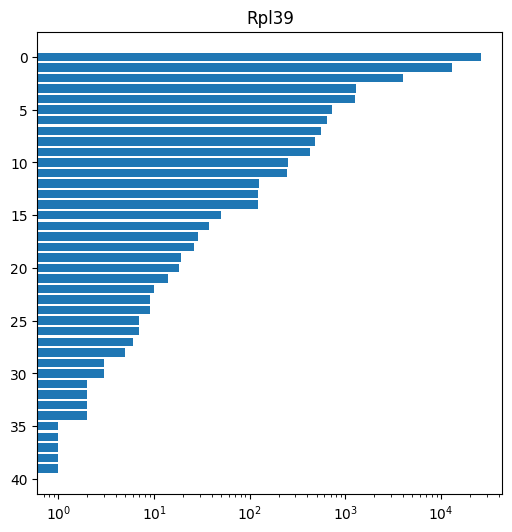

/tmp/ipykernel_40589/3803599367.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_edit_info['num'] = 1


<Figure size 600x600 with 0 Axes>

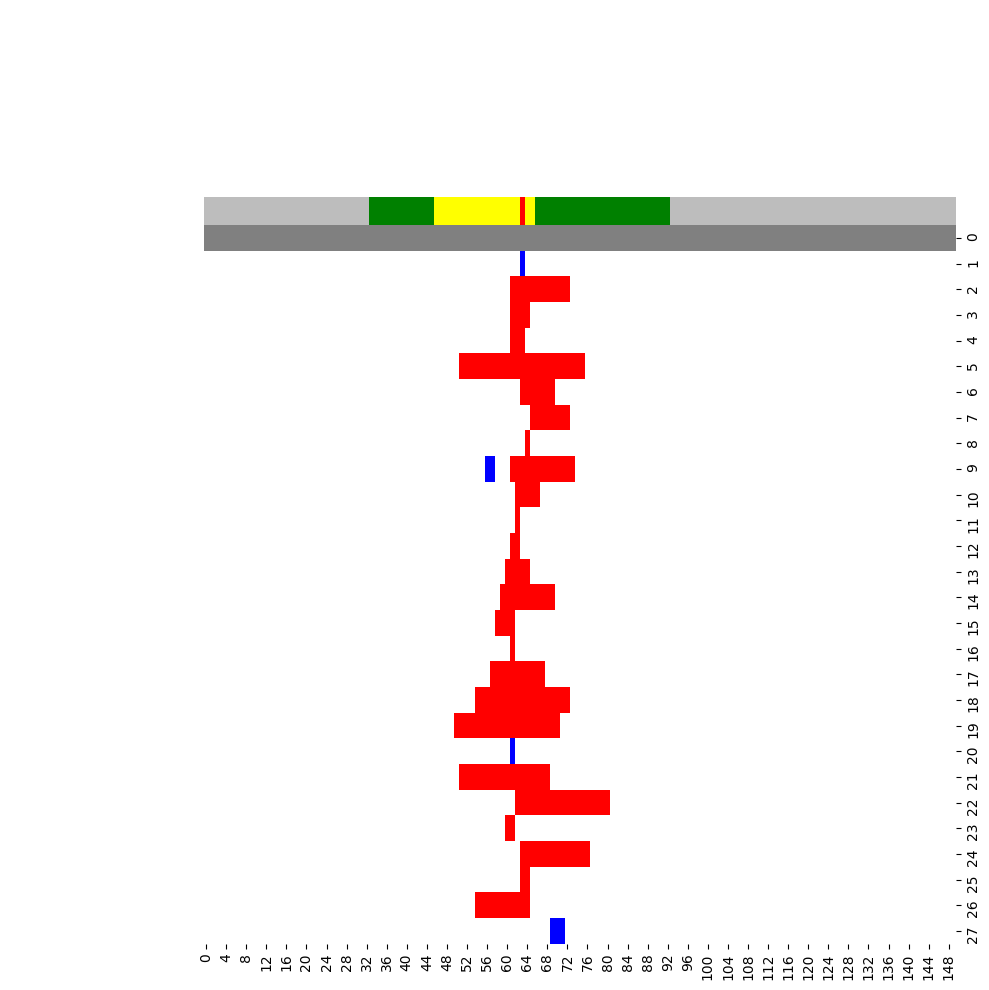

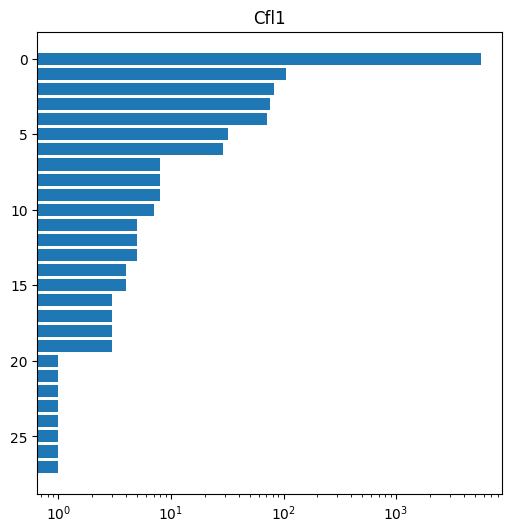

/tmp/ipykernel_40589/3803599367.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_edit_info['num'] = 1


<Figure size 600x600 with 0 Axes>

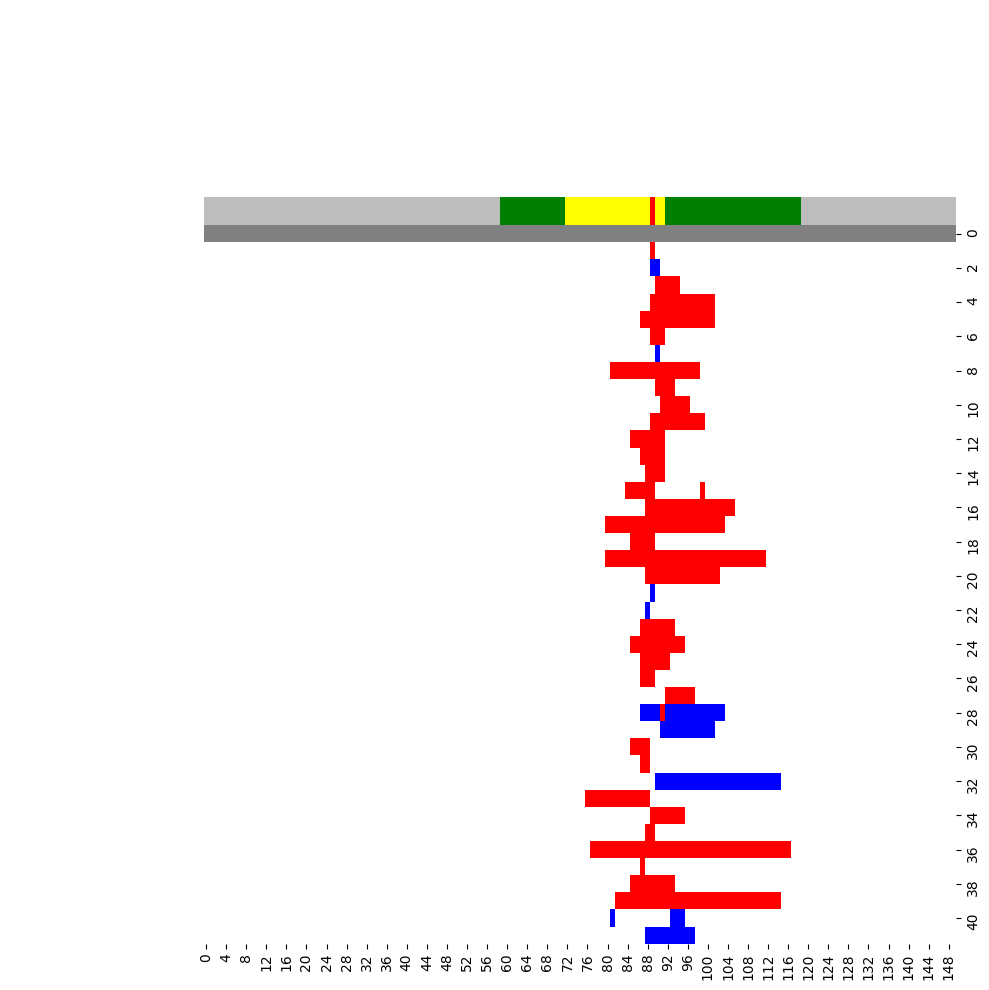

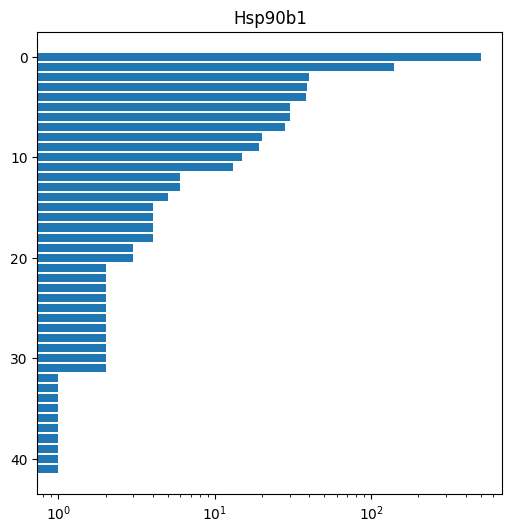

/tmp/ipykernel_40589/3803599367.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_edit_info['num'] = 1


<Figure size 600x600 with 0 Axes>

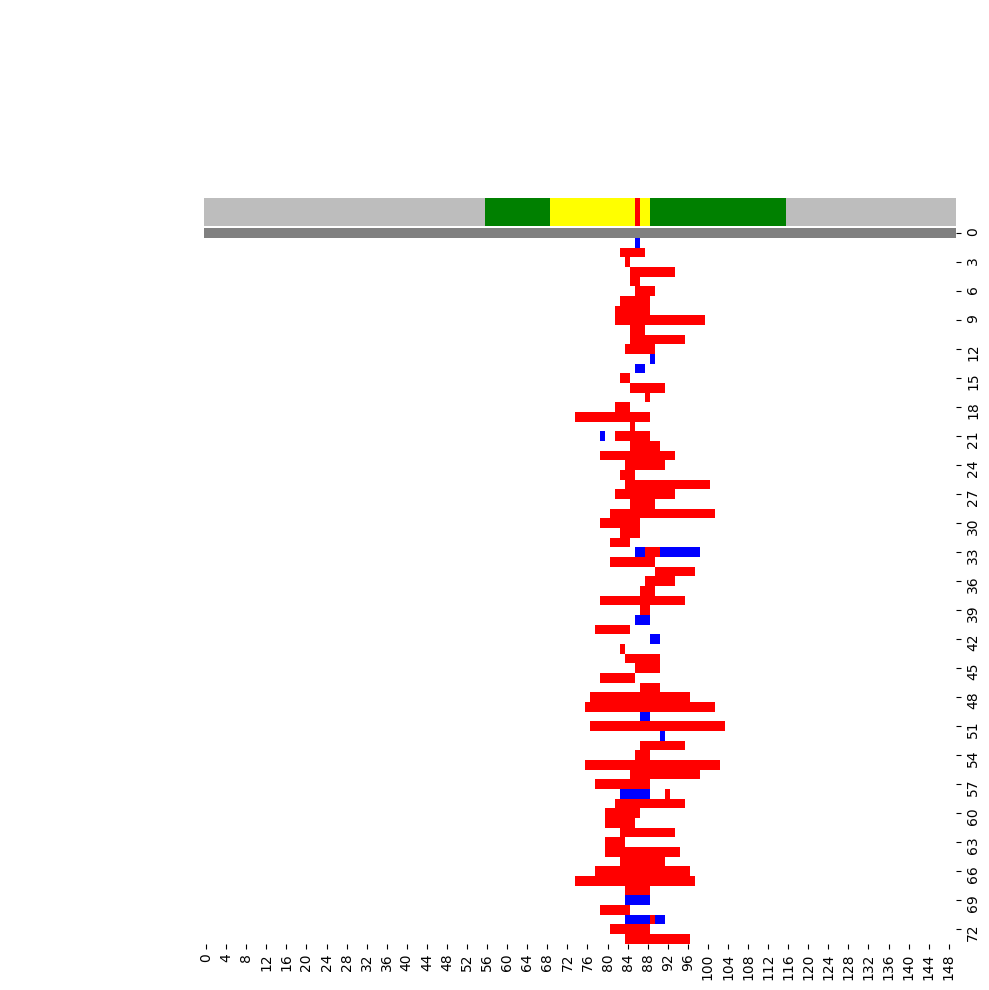

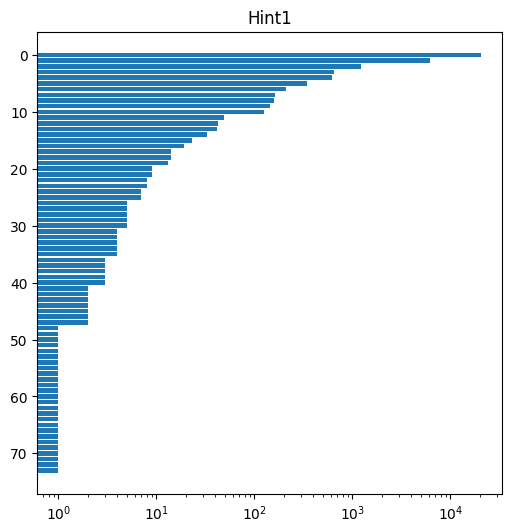

/tmp/ipykernel_40589/3803599367.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_edit_info['num'] = 1


<Figure size 600x600 with 0 Axes>

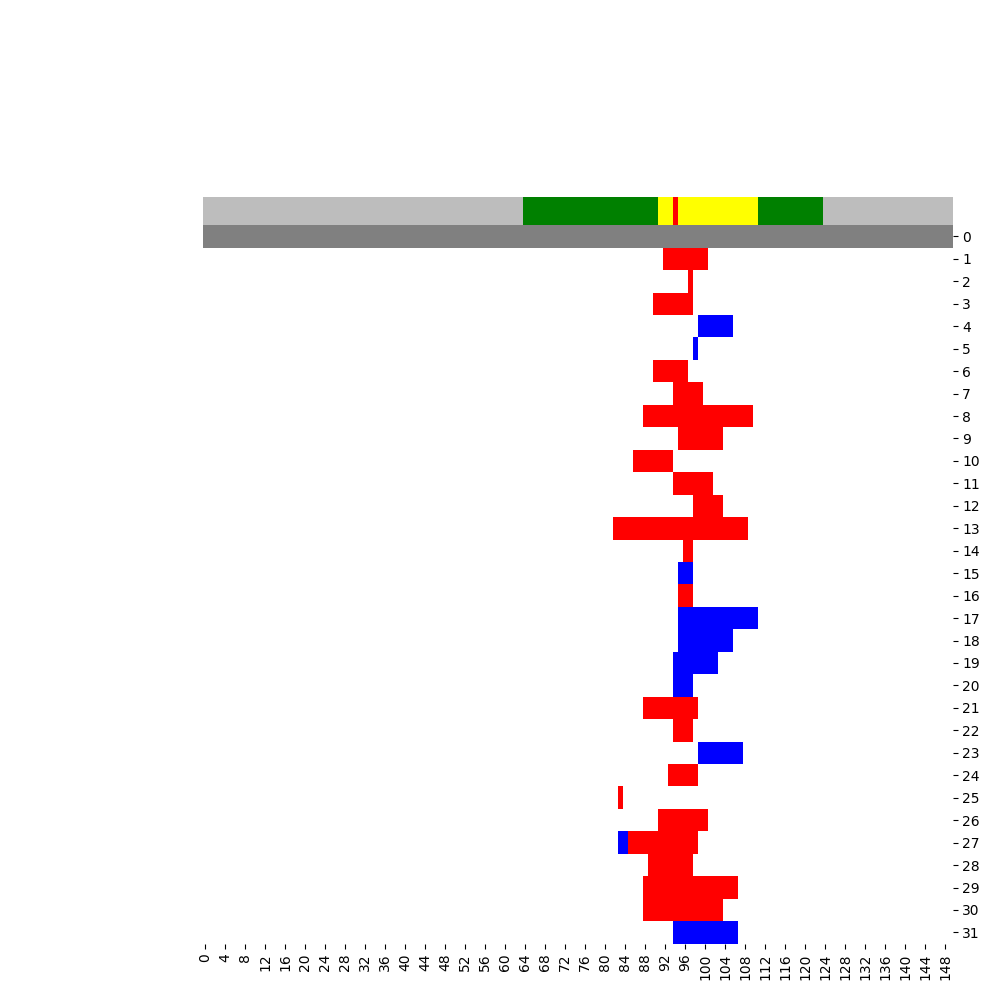

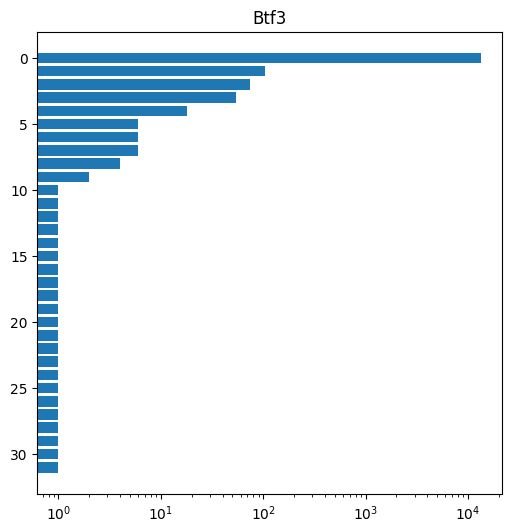

/tmp/ipykernel_40589/3803599367.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_edit_info['num'] = 1


<Figure size 600x600 with 0 Axes>

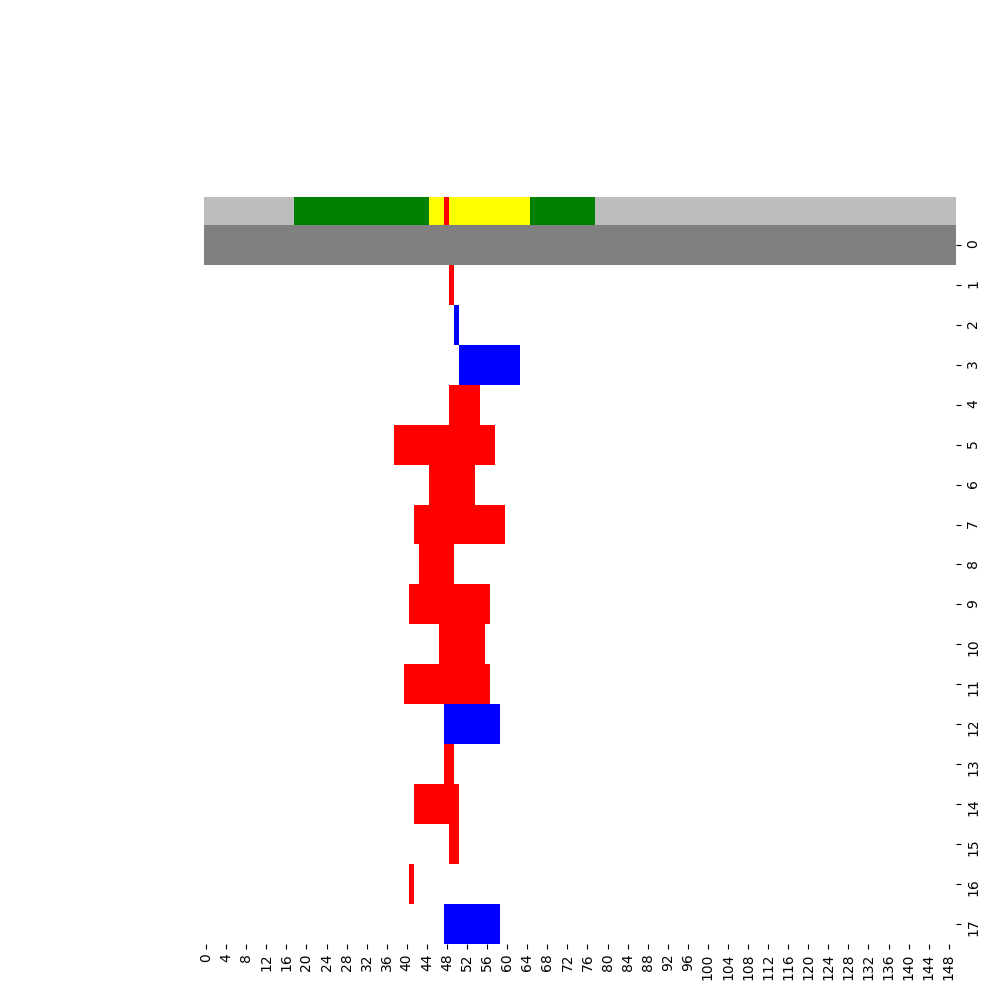

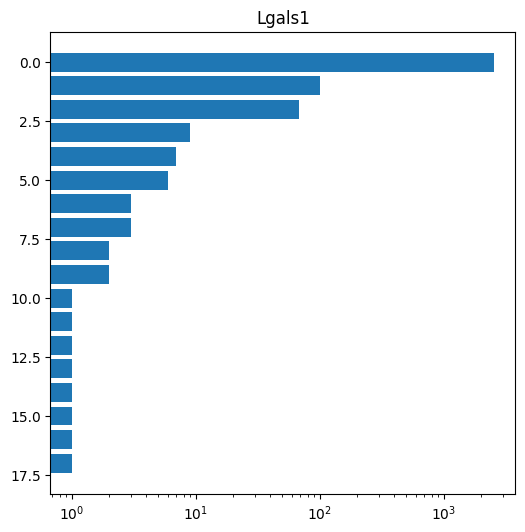

/tmp/ipykernel_40589/3803599367.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_edit_info['num'] = 1


<Figure size 600x600 with 0 Axes>

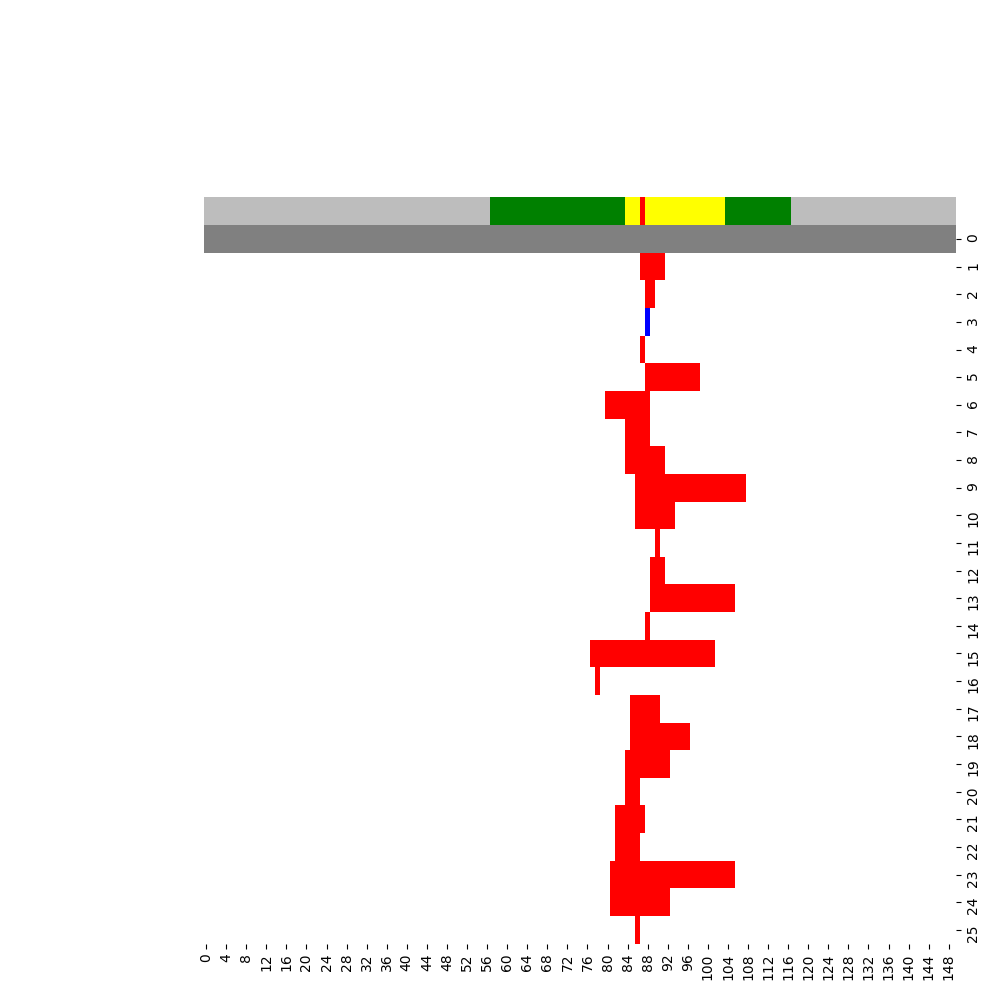

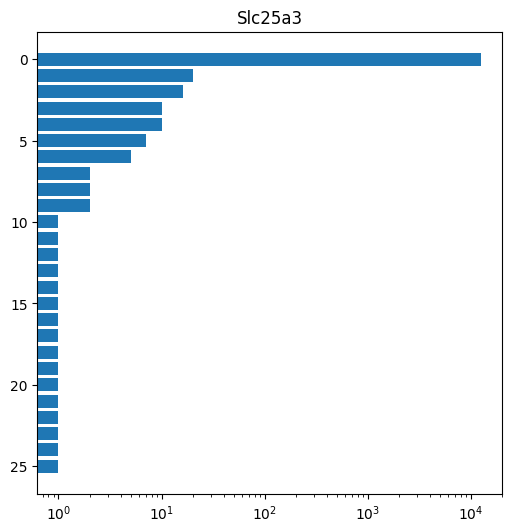

/tmp/ipykernel_40589/3803599367.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_edit_info['num'] = 1


<Figure size 600x600 with 0 Axes>

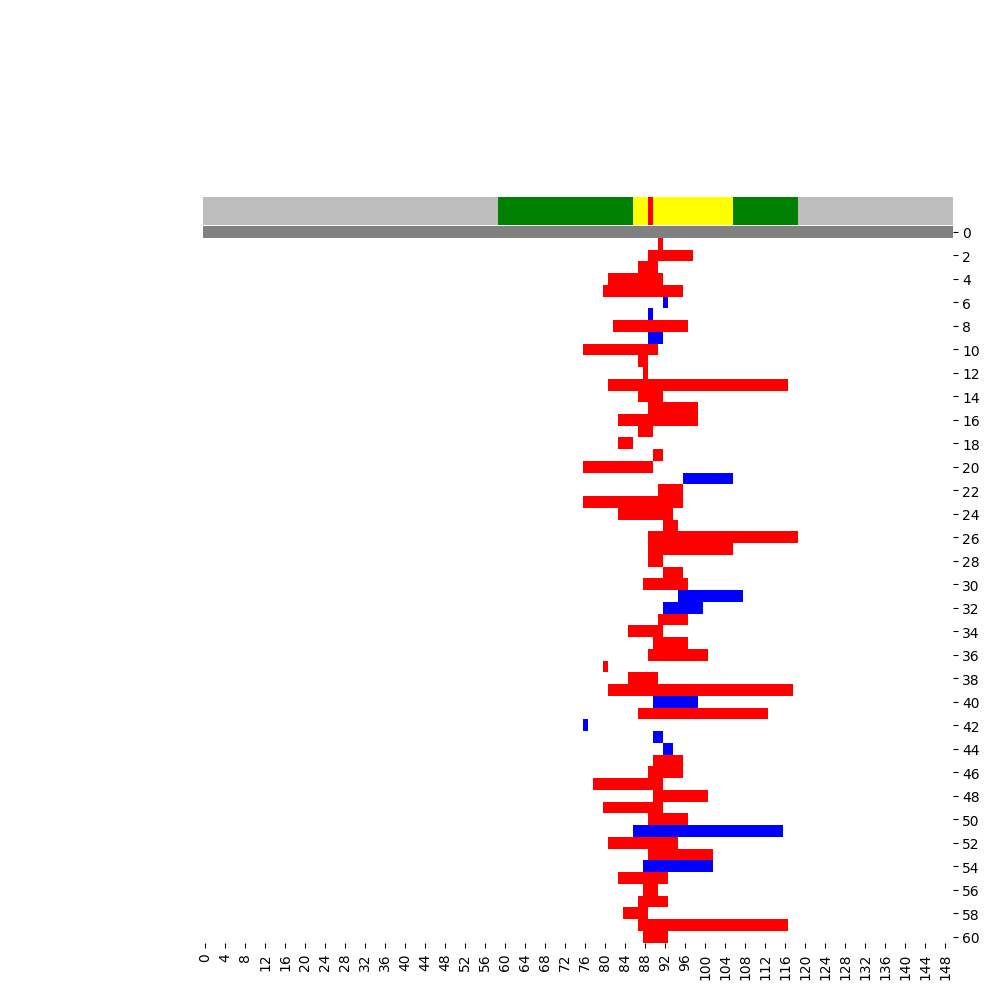

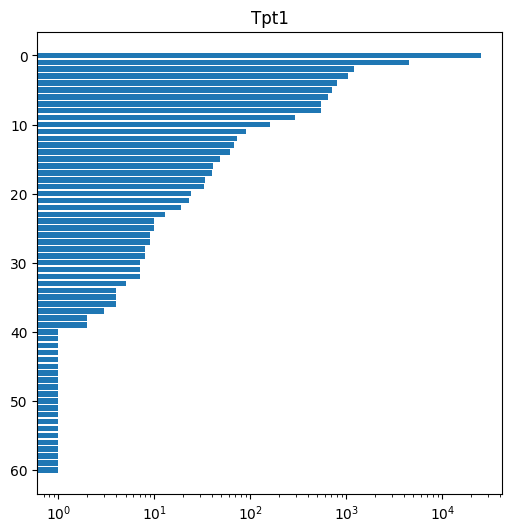

/tmp/ipykernel_40589/3803599367.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_edit_info['num'] = 1


<Figure size 600x600 with 0 Axes>

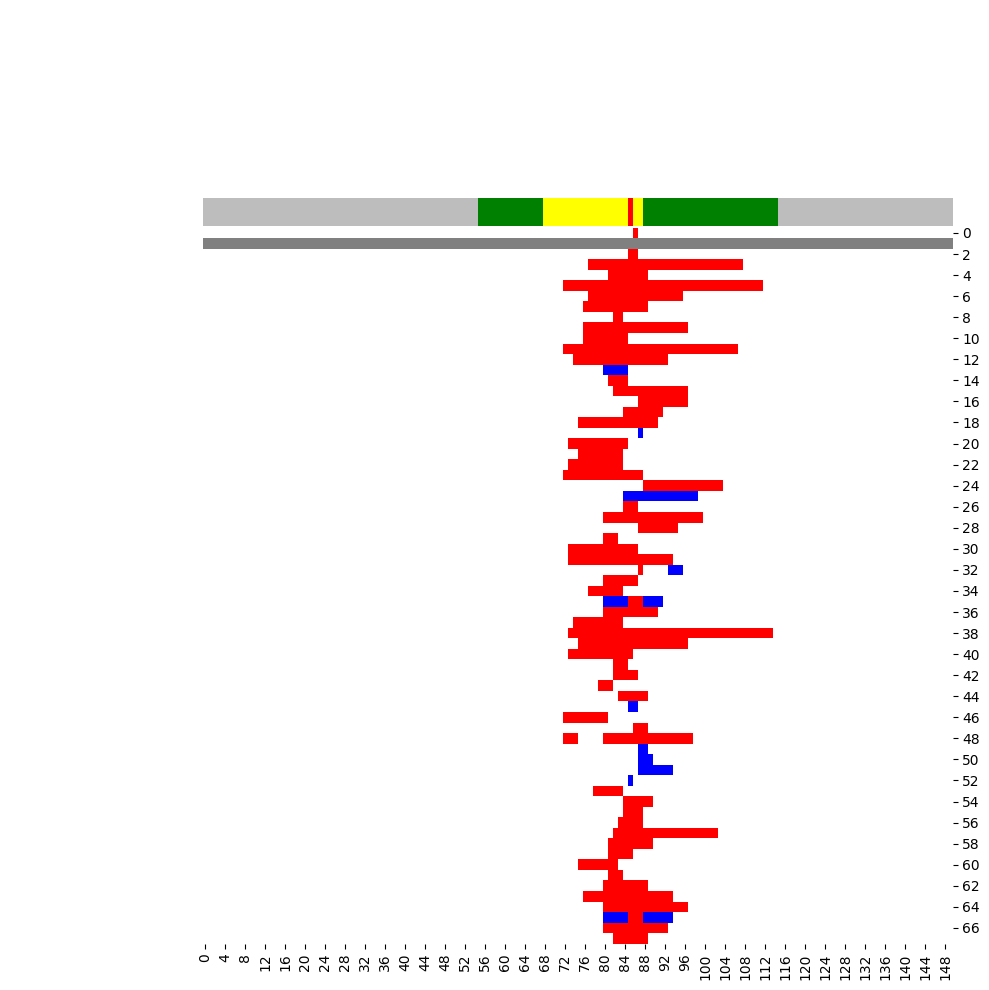

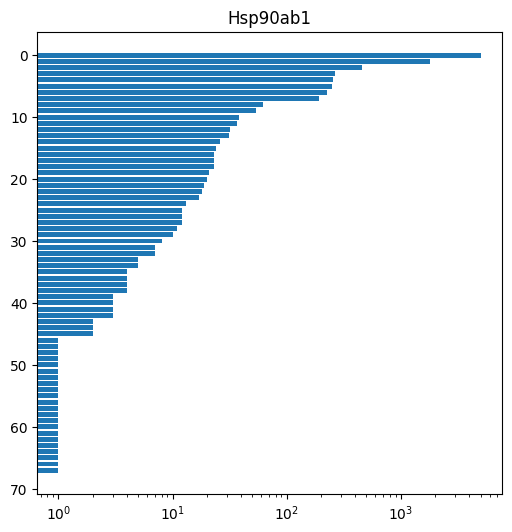

/tmp/ipykernel_40589/3803599367.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_edit_info['num'] = 1


<Figure size 600x600 with 0 Axes>

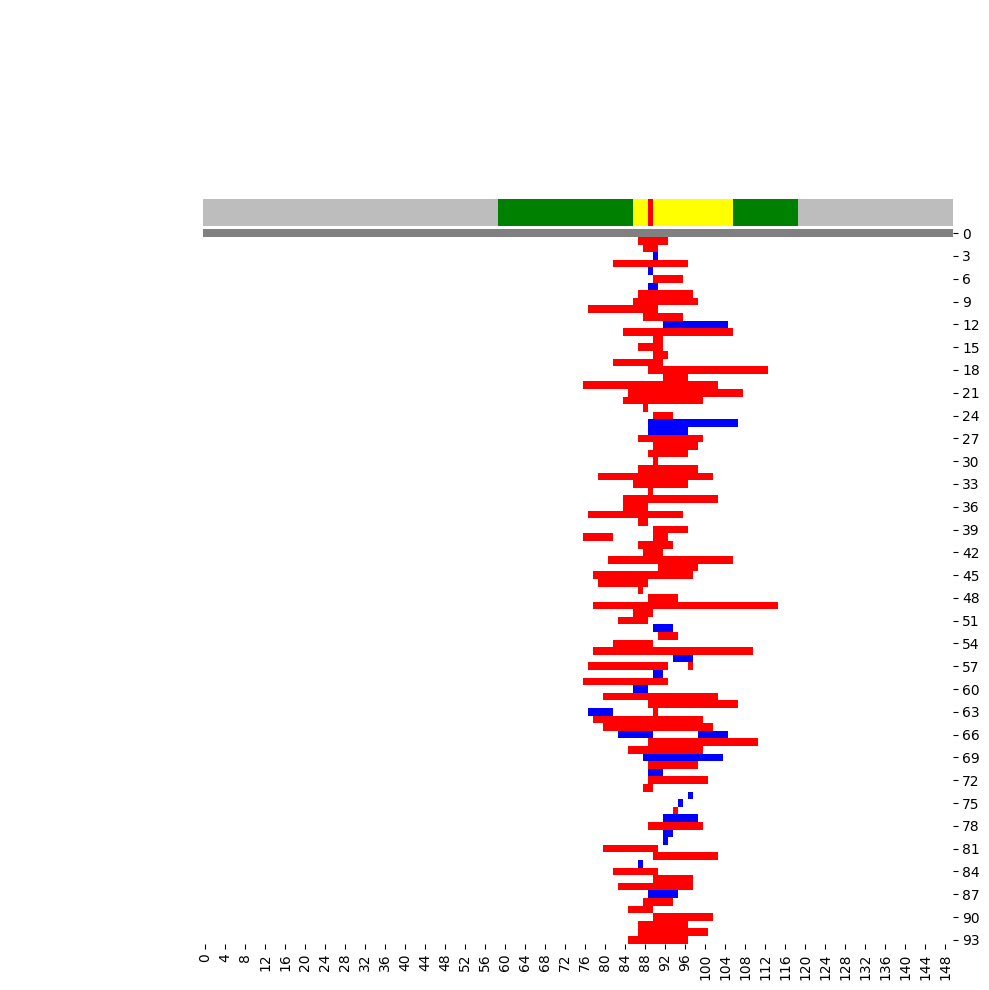

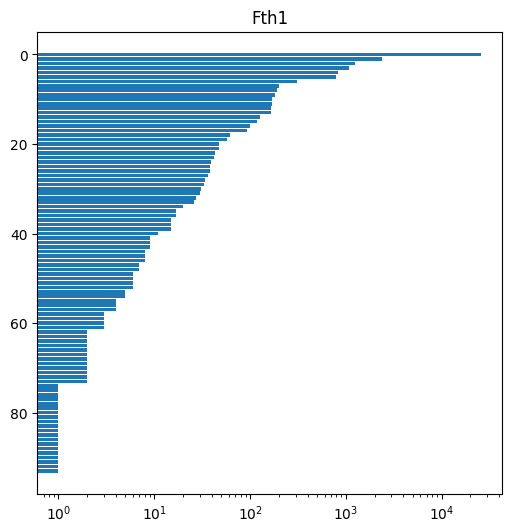

In [32]:
edit_num = []

edit_info = allele_table
gene_names=['Calr', 'Myl6', 'Calm2', 'Rpl39', 'Cfl1', 'Acta1', 'Hsp90b1', 'Calm1', 
            'Hint1', 'Btf3', 'Lgals1', 'Slc25a3', 'Tpt1', 'Hsp90ab1', 'Fth1']
cut_sites = [80,91,93,87,63,89,89,84,86,94,48,87,89,85,89]
wc = [-17,-3,-3,-17,-3,-17,-3,-17,-3,-17,-17,-17,-17,-3,-17]

counter = 0
for intBC in gene_names:
    if intBC in ['Calm1','Acta1']:
        counter += 1
        continue
    gene_edit_info = edit_info[edit_info['intBC']==intBC]
    #gene_edit_info['num'] = 1
    gene_edit_info = gene_edit_info.groupby(['r1'])['num'].sum().reset_index().sort_values(by='num',ascending=False)
    gene_edit_indel_info = gene_edit_info.groupby(['r1'])['num'].sum().reset_index().sort_values(by='num',ascending=False)
    edit_num.append((intBC,gene_edit_indel_info.shape[0]-1))
    
    edit_matrix = edit_matrix_make(gene_edit_info)

    colors = {0:'white', 1: 'blue', -1:'red',2:'gray'}
    color_array = [colors[i] for i in range(min(colors.keys()), max(colors.keys()) + 1)]
    cmap = ListedColormap(color_array)
    plt.figure(figsize=(6, 6))
    data_colors = []
    if wc[counter] == -17:
        sgRNA_binding_region = range(cut_sites[counter]-3,cut_sites[counter]+17)
    else:
        sgRNA_binding_region = range(cut_sites[counter]-17,cut_sites[counter]+3)
    
    cut_site_region = range(cut_sites[counter]-30,cut_sites[counter]+30)
    for i in range(0,150):
        if i == cut_sites[counter]:
            data_colors.append('red')
        elif i in sgRNA_binding_region:
            data_colors.append('yellow')
        elif i in cut_site_region:
            data_colors.append('green')
        else:
            data_colors.append('#bdbdbd')
    ax = sns.clustermap(edit_matrix, cmap=cmap,row_cluster=False,col_cluster=False,col_colors=data_colors)
    ax.cax.set_visible(False)
    plt.title(intBC)
    plt.show()
    
    plt.figure(figsize=(6, 6))
    plt.barh(gene_edit_info.index, gene_edit_info['num'])
    plt.xscale('log')
    plt.gca().invert_yaxis()
    plt.title(intBC)
    plt.show()
    
    counter += 1

## couple with lineage clone 

In [60]:
cell_lineage = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/spatial_cell_lineage_new.csv',header=0)
cell_lineage['CellID'] = cell_lineage['CellID'].astype('str')
cell_lineage = cell_lineage[['CellID','lineageGrp']]
cell_lineage

,CellID,lineageGrp
0,8400_3300,11
1,8800_3750,11
2,8850_3250,11
3,5850_5900,11
4,5850_5700,11
...,...,...
12744,5550_3200,11
12745,2700_9500,56
12746,5550_3300,3
12747,5550_3450,11


In [62]:
cell_lineage.loc[cell_lineage.CellID=='3350_9050',]

,CellID,lineageGrp
10198,3350_9050,13


In [63]:
allele_table = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/allele_table.csv',header=0,na_filter=False)
allele_table['CellID'] = allele_table['CellID'].astype('str')
allele_table

,CellID,intBC,r1,allele,readCount,UMI,UMI_ratio
0,3350_9100,Fth1,None,None,7773,103,0.990385
1,3400_9100,Fth1,None,None,5370,73,0.924051
2,3400_9150,Fth1,None,None,5107,66,0.929577
3,3050_9600,Fth1,None,None,4829,50,0.892857
4,2750_9150,Fth1,None,None,4069,50,0.925926
...,...,...,...,...,...,...,...
313614,9800_11150,Cfl1,None,None,6,2,1.000000
313615,9800_2750,Rpl39,88:2D,88:2D,6,2,0.181818
313616,9800_9400,Hsp90ab1,None,None,6,2,0.400000
313617,9900_7000,Rpl39,88:2D,88:2D,6,2,0.111111


In [64]:
allele_table = pd.merge(allele_table,cell_lineage,how='inner',on=['CellID'])

In [65]:
len(set(allele_table['CellID']))

12748

## make 0-1 matrix

In [66]:
allele_table = allele_table[allele_table['r1'] != 'None']
allele_table

,CellID,intBC,r1,allele,readCount,UMI,UMI_ratio,lineageGrp
8,3400_9150,Hint1,87:1I,87:1I,146,2,0.250000,2
9,3400_9150,Myl6,92:1I,92:1I,29,2,0.142857,2
12,3200_9550,Hint1,87:1I,87:1I,463,16,0.842105,3
17,3200_9550,Rpl39,88:2D,88:2D,143,3,0.068182,3
18,3200_9550,Hsp90ab1,87:1D,87:1D,283,2,0.666667,3
...,...,...,...,...,...,...,...,...
127579,5450_7450,Myl6,92:1I,92:1I,57,2,0.500000,11
127584,8300_8900,Hsp90ab1,87:1D,87:1D,49,2,0.500000,11
127589,11500_11600,Fth1,80:10D,80:10D,155,2,0.400000,45
127591,1700_3950,Fth1,93:13I,93:13I,62,2,0.400000,7


In [67]:
gene_names = set(allele_table['intBC'])

cell_mutation_matrix = pd.DataFrame(index=list(set(allele_table['CellID'])))
for gene in gene_names:
    print(gene)
    allele_table_gene = allele_table[allele_table['intBC']==gene]
    if allele_table_gene.shape[0] == 0:
        continue
    df = allele_table_gene.pivot(index='CellID', columns='r1', values='UMI')
    df= df.fillna(0)
    df[df > 0] = 1
    df.columns = [gene + '_' + indel for indel in df.columns]
    cell_mutation_matrix = cell_mutation_matrix.join(df, how='outer')
    cell_mutation_matrix = cell_mutation_matrix.fillna(0)

cell_mutation_matrix = cell_mutation_matrix.loc[:, (cell_mutation_matrix != 0).any(axis=0)]

cell_mutation_matrix.loc['synthetic'] = [ 0 for i in range(0,cell_mutation_matrix.shape[1])]
cell_mutation_matrix = cell_mutation_matrix.astype(int)


for lineageGrp in cell_lineage['lineageGrp'].unique():

    cell_mutation_matrix_lineageGrp = cell_mutation_matrix.loc[cell_mutation_matrix.index.isin(cell_lineage[cell_lineage['lineageGrp'].isin([lineageGrp])]['CellID']),:]           
    cell_mutation_matrix_lineageGrp = cell_mutation_matrix_lineageGrp.astype(int)
    if cell_mutation_matrix_lineageGrp.shape[0] < 50:
        continue

    cell_mutation_matrix_lineageGrp = cell_mutation_matrix_lineageGrp.loc[:, (cell_mutation_matrix_lineageGrp != 0).any(axis=0)]
    if cell_mutation_matrix_lineageGrp.shape[1] == 0:
        continue
    cell_mutation_matrix_lineageGrp.loc['synthetic'] = [ 0 for i in range(0,cell_mutation_matrix_lineageGrp.shape[1])]

    cell_mutation_matrix_lineageGrp.to_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/trees/bin50/'+'cell_mutation_matrix-C'+str(lineageGrp)+'-'+str(cell_mutation_matrix_lineageGrp.shape[0])+'.csv')

    cell_mutation_sequence = cell_mutation_matrix_lineageGrp.apply(lambda row: ''.join(row.astype(str)), axis=1)
    output_file = '/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/trees/bin50/'+ 'cell_mutation_matrix-C'+str(lineageGrp)+'-'+str(cell_mutation_matrix_lineageGrp.shape[0])+'.phy'
    with open(output_file, 'w') as file:
        file.write(f"{cell_mutation_matrix_lineageGrp.shape[0]} \t{cell_mutation_matrix_lineageGrp.shape[1]}\n") 
        for index, line in cell_mutation_sequence.items():
            file.write(f"{index}\t{line}\n")  



Hsp90ab1
Myl6
Tpt1
Cfl1
Hint1
Hsp90b1
Calr
Lgals1
Btf3
Slc25a3
Calm2
Rpl39
Fth1


# single cell clone vs spatial clone

In [73]:
# C5
mutation_mtx_sc = pd.read_csv("/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/trees/merge_all_experiments/T2_and_T3/polytomy/cell_mutation_matrix-C5-1671.csv",header=0,index_col=0)
mutation_mtx_st = pd.read_csv("/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/trees/bin50/cell_mutation_matrix-C5-228.csv",header=0,index_col=0)
C5_mutation = set(mutation_mtx_sc.columns).intersection(set(mutation_mtx_st.columns))
C5_mutation

{'Btf3_98:1D',
 'Calm2_93:4D',
 'Calm2_95:7D',
 'Calr_74:14D',
 'Calr_80:22D',
 'Calr_81:1D',
 'Calr_85:1D',
 'Cfl1_62:3D',
 'Cfl1_62:4D',
 'Fth1_83:15D',
 'Fth1_84:6D',
 'Fth1_85:22D',
 'Fth1_88:1I',
 'Fth1_88:6D',
 'Fth1_89:3D',
 'Fth1_90:18I',
 'Fth1_90:1I',
 'Fth1_90:8I',
 'Fth1_91:1I',
 'Fth1_91:4D',
 'Fth1_91:6D',
 'Fth1_93:13I',
 'Hint1_84:5D',
 'Hint1_85:17D',
 'Hint1_85:1D',
 'Hint1_86:2D',
 'Hint1_86:9D',
 'Hint1_87:1I',
 'Hint1_87:4D',
 'Hsp90ab1_73:40D',
 'Hsp90ab1_82:8D',
 'Hsp90ab1_87:1D',
 'Hsp90b1_90:1D',
 'Hsp90b1_91:4D',
 'Myl6_89:8D',
 'Myl6_90:2D',
 'Myl6_90:3D',
 'Myl6_90:5D',
 'Myl6_91:1D',
 'Myl6_92:1I',
 'Myl6_92:2D',
 'Myl6_92:2I',
 'Myl6_92:3D',
 'Myl6_93:1I',
 'Myl6_96:5D',
 'Rpl39_87:10D',
 'Rpl39_87:1D',
 'Rpl39_87:4D',
 'Rpl39_88:1I',
 'Rpl39_88:2D',
 'Rpl39_88:3D',
 'Rpl39_93:15I',
 'Tpt1_81:16D',
 'Tpt1_82:11D',
 'Tpt1_83:15D',
 'Tpt1_89:1D',
 'Tpt1_90:1I',
 'Tpt1_91:2D',
 'Tpt1_92:1D',
 'Tpt1_92:5D',
 'Tpt1_93:1I'}

In [74]:
# C45
mutation_mtx_sc = pd.read_csv("/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/trees/merge_all_experiments/T2_and_T3/polytomy/cell_mutation_matrix-C45-71.csv",header=0,index_col=0)
mutation_mtx_st = pd.read_csv("/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/trees/bin50/cell_mutation_matrix-C45-379.csv",header=0,index_col=0)
C45_mutation = set(mutation_mtx_sc.columns).intersection(set(mutation_mtx_st.columns))
C45_mutation

{'Calm2_92:2D',
 'Calm2_93:4D',
 'Calm2_95:7D',
 'Calr_76:6D',
 'Calr_77:4D',
 'Calr_78:11D',
 'Calr_81:1D',
 'Calr_81:4D',
 'Fth1_83:15D',
 'Fth1_89:3D',
 'Fth1_90:1I',
 'Fth1_91:1I',
 'Hint1_85:1D',
 'Hint1_86:2D',
 'Hint1_87:1I',
 'Hsp90ab1_78:19D',
 'Hsp90ab1_82:8D',
 'Hsp90ab1_86:2D',
 'Hsp90ab1_87:1D',
 'Hsp90b1_86:5D',
 'Hsp90b1_88:5D',
 'Hsp90b1_90:1D',
 'Hsp90b1_91:1I',
 'Myl6_90:3D',
 'Rpl39_83:8D',
 'Rpl39_85:9D',
 'Rpl39_88:2D',
 'Tpt1_81:16D',
 'Tpt1_84:16D',
 'Tpt1_90:1I',
 'Tpt1_92:1D',
 'Tpt1_93:1I'}

In [75]:
# C15
mutation_mtx_sc = pd.read_csv("/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/trees/merge_all_experiments/T2_and_T3/polytomy/cell_mutation_matrix-C15-405.csv",header=0,index_col=0)
mutation_mtx_st = pd.read_csv("/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/trees/bin50/cell_mutation_matrix-C15-203.csv",header=0,index_col=0)
C15_mutation = set(mutation_mtx_sc.columns).intersection(set(mutation_mtx_st.columns))
C15_mutation

{'Calm2_95:7D',
 'Calr_71:8I80:1D',
 'Calr_74:14D',
 'Calr_74:29D',
 'Calr_81:1D',
 'Calr_81:4D',
 'Calr_84:2I',
 'Cfl1_51:21D',
 'Fth1_77:27D',
 'Fth1_83:15D',
 'Fth1_85:22D',
 'Fth1_88:6D',
 'Fth1_89:3D',
 'Fth1_90:1I',
 'Fth1_90:2I',
 'Fth1_90:8D',
 'Fth1_91:1I',
 'Fth1_91:3D',
 'Fth1_91:4D',
 'Fth1_91:6D',
 'Fth1_91:9D',
 'Fth1_93:5D',
 'Hint1_84:2D',
 'Hint1_84:5D',
 'Hint1_84:6D',
 'Hint1_85:1D',
 'Hint1_85:6D',
 'Hint1_86:2D',
 'Hint1_86:7D',
 'Hint1_87:1I',
 'Hint1_87:4D',
 'Hsp90ab1_73:40D',
 'Hsp90ab1_77:13D',
 'Hsp90ab1_81:13D',
 'Hsp90ab1_81:20D',
 'Hsp90ab1_82:8D',
 'Hsp90ab1_86:2D',
 'Hsp90ab1_87:1D',
 'Hsp90b1_88:15D',
 'Myl6_89:8D',
 'Myl6_90:2D',
 'Myl6_90:3D',
 'Myl6_91:1D',
 'Myl6_92:1I',
 'Myl6_92:3D',
 'Myl6_93:1I',
 'Rpl39_83:8D',
 'Rpl39_85:7D',
 'Rpl39_87:4D',
 'Rpl39_88:1I',
 'Rpl39_88:2D',
 'Slc25a3_87:1D',
 'Slc25a3_89:2D',
 'Tpt1_81:16D',
 'Tpt1_82:11D',
 'Tpt1_82:36D',
 'Tpt1_83:15D',
 'Tpt1_84:16D',
 'Tpt1_90:1I',
 'Tpt1_90:3I',
 'Tpt1_92:1D',
 'Tpt1_93:1I

In [76]:
# C1
mutation_mtx_sc = pd.read_csv("/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/trees/merge_all_experiments/T2_and_T3/polytomy/cell_mutation_matrix-C1-23342.csv",header=0,index_col=0)
mutation_mtx_st = pd.read_csv("/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/trees/bin50/cell_mutation_matrix-C1-193.csv",header=0,index_col=0)
C1_mutation = set(mutation_mtx_sc.columns).intersection(set(mutation_mtx_st.columns))
C1_mutation

{'Btf3_91:8D',
 'Btf3_98:1D',
 'Calr_71:8I80:1D',
 'Calr_74:14D',
 'Calr_76:12D',
 'Calr_76:6D',
 'Calr_78:11D',
 'Calr_80:5D',
 'Calr_81:1D',
 'Calr_84:2I',
 'Calr_85:14I',
 'Cfl1_52:25D',
 'Cfl1_58:11D',
 'Cfl1_62:4D',
 'Fth1_77:27D',
 'Fth1_78:14D',
 'Fth1_83:15D',
 'Fth1_85:22D',
 'Fth1_87:13D',
 'Fth1_88:6D',
 'Fth1_89:1D',
 'Fth1_89:3D',
 'Fth1_89:8D',
 'Fth1_90:1I',
 'Fth1_90:2I',
 'Fth1_91:1I',
 'Fth1_91:6D',
 'Fth1_93:13I',
 'Fth1_95:1D',
 'Hint1_83:18D',
 'Hint1_84:3D',
 'Hint1_84:5D',
 'Hint1_85:1D',
 'Hint1_86:2D',
 'Hint1_86:3D',
 'Hint1_86:9D',
 'Hint1_87:1I',
 'Hint1_87:2I',
 'Hint1_87:4D',
 'Hsp90ab1_73:40D',
 'Hsp90ab1_76:9D',
 'Hsp90ab1_77:13D',
 'Hsp90ab1_78:19D',
 'Hsp90ab1_86:2D',
 'Hsp90ab1_87:1D',
 'Hsp90ab1_88:10D',
 'Hsp90b1_90:1D',
 'Hsp90b1_91:1I',
 'Hsp90b1_91:4D',
 'Hsp90b1_92:6D',
 'Lgals1_50:1D',
 'Lgals1_51:1I',
 'Myl6_88:16D',
 'Myl6_89:8D',
 'Myl6_90:2D',
 'Myl6_90:3D',
 'Myl6_91:1D',
 'Myl6_92:1D',
 'Myl6_92:1I',
 'Myl6_92:2D',
 'Myl6_92:3D',
 'Myl6_9

In [77]:
# C82
mutation_mtx_sc = pd.read_csv("/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/trees/merge_all_experiments/T2_and_T3/polytomy/cell_mutation_matrix-C82-171.csv",header=0,index_col=0)
mutation_mtx_st = pd.read_csv("/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/trees/bin50/cell_mutation_matrix-C82-355.csv",header=0,index_col=0)
C82_mutation = set(mutation_mtx_sc.columns).intersection(set(mutation_mtx_st.columns))
C82_mutation

{'Calm2_95:7D',
 'Calr_74:14D',
 'Calr_80:5D',
 'Calr_80:6D',
 'Calr_81:1D',
 'Cfl1_52:25D',
 'Cfl1_64:1I',
 'Cfl1_64:7D',
 'Fth1_78:14D',
 'Fth1_80:23D',
 'Fth1_83:15D',
 'Fth1_88:6D',
 'Fth1_89:3D',
 'Fth1_89:8D',
 'Fth1_90:1I',
 'Fth1_91:1I',
 'Fth1_91:4D',
 'Fth1_91:6D',
 'Hint1_82:9D',
 'Hint1_83:18D',
 'Hint1_84:2D',
 'Hint1_84:5D',
 'Hint1_85:1D',
 'Hint1_86:9D',
 'Hint1_87:1I',
 'Hint1_87:4D',
 'Hint1_90:1I',
 'Hsp90ab1_73:40D',
 'Hsp90ab1_78:31D',
 'Hsp90ab1_82:8D',
 'Hsp90ab1_87:1D',
 'Hsp90b1_90:13D',
 'Hsp90b1_90:1D',
 'Hsp90b1_91:4D',
 'Myl6_79:30D',
 'Myl6_89:8D',
 'Myl6_90:2D',
 'Myl6_90:3D',
 'Myl6_90:5D',
 'Myl6_91:1D',
 'Myl6_92:1I',
 'Myl6_92:3D',
 'Myl6_93:1I',
 'Rpl39_87:1D',
 'Rpl39_87:4D',
 'Rpl39_88:1I',
 'Rpl39_88:2D',
 'Rpl39_88:3D',
 'Rpl39_93:15I',
 'Slc25a3_81:9D',
 'Slc25a3_88:5D',
 'Slc25a3_89:1I',
 'Slc25a3_89:2D',
 'Tpt1_81:16D',
 'Tpt1_82:11D',
 'Tpt1_90:1I',
 'Tpt1_92:1D',
 'Tpt1_93:1I'}

In [78]:
# C9
mutation_mtx_sc = pd.read_csv("/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/trees/merge_all_experiments/T2_and_T3/polytomy/cell_mutation_matrix-C9-866.csv",header=0,index_col=0)
mutation_mtx_st = pd.read_csv("/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/trees/bin50/cell_mutation_matrix-C9-221.csv",header=0,index_col=0)
C9_mutation = set(mutation_mtx_sc.columns).intersection(set(mutation_mtx_st.columns))
C9_mutation

{'Btf3_91:8D',
 'Btf3_98:1D',
 'Calr_72:12D',
 'Calr_74:14D',
 'Calr_77:5D',
 'Calr_78:11D',
 'Calr_80:22D',
 'Calr_80:6D',
 'Calr_81:1D',
 'Calr_85:1D',
 'Cfl1_52:25D',
 'Cfl1_62:12D',
 'Cfl1_62:3D',
 'Cfl1_63:1D',
 'Cfl1_63:5D',
 'Cfl1_64:1I',
 'Fth1_83:15D',
 'Fth1_85:22D',
 'Fth1_88:6D',
 'Fth1_89:3D',
 'Fth1_89:6D',
 'Fth1_90:1I',
 'Fth1_90:2I',
 'Fth1_91:1I',
 'Fth1_91:6D',
 'Fth1_93:13I',
 'Fth1_93:5D',
 'Hint1_80:15D',
 'Hint1_84:5D',
 'Hint1_84:6D',
 'Hint1_85:1D',
 'Hint1_85:6D',
 'Hint1_86:2D',
 'Hint1_86:9D',
 'Hint1_87:1I',
 'Hint1_89:1D',
 'Hsp90ab1_73:40D',
 'Hsp90ab1_74:12D',
 'Hsp90ab1_77:13D',
 'Hsp90ab1_82:4D',
 'Hsp90ab1_82:8D',
 'Hsp90ab1_85:15I',
 'Hsp90ab1_86:2D',
 'Hsp90ab1_87:1D',
 'Hsp90b1_90:13D',
 'Lgals1_50:1D',
 'Myl6_86:6D',
 'Myl6_88:16D',
 'Myl6_89:8D',
 'Myl6_90:2D',
 'Myl6_90:3D',
 'Myl6_90:5D',
 'Myl6_91:1D',
 'Myl6_92:1I',
 'Myl6_92:2I',
 'Myl6_92:3D',
 'Myl6_93:1I',
 'Myl6_96:14I',
 'Myl6_96:5D',
 'Rpl39_83:8D',
 'Rpl39_85:7D',
 'Rpl39_87:10D',
 'R

In [79]:
# C55
mutation_mtx_sc = pd.read_csv("/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/trees/merge_all_experiments/T2_and_T3/polytomy/cell_mutation_matrix-C55-54.csv",header=0,index_col=0)
mutation_mtx_st = pd.read_csv("/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/trees/bin50/cell_mutation_matrix-C55-397.csv",header=0,index_col=0)
C55_mutation = set(mutation_mtx_sc.columns).intersection(set(mutation_mtx_st.columns))
C55_mutation

{'Btf3_98:1D',
 'Calm2_90:4D',
 'Calm2_95:1I',
 'Calm2_95:7D',
 'Calr_75:22I85:2I',
 'Calr_78:11D',
 'Calr_80:5D',
 'Calr_81:1D',
 'Cfl1_62:4D',
 'Cfl1_64:1I',
 'Fth1_78:14D',
 'Fth1_83:15D',
 'Fth1_87:11D',
 'Fth1_87:4D',
 'Fth1_88:12D',
 'Fth1_88:5D',
 'Fth1_88:6D',
 'Fth1_89:1D',
 'Fth1_89:3D',
 'Fth1_89:8D',
 'Fth1_90:1D',
 'Fth1_90:1I',
 'Fth1_91:1D',
 'Fth1_91:1I',
 'Fth1_91:2D',
 'Fth1_91:3D',
 'Fth1_91:4D',
 'Fth1_91:9D',
 'Hint1_84:5D',
 'Hint1_85:1D',
 'Hint1_87:1I',
 'Hsp90ab1_82:8D',
 'Hsp90ab1_86:2D',
 'Hsp90ab1_87:1D',
 'Hsp90b1_90:1D',
 'Hsp90b1_90:3D',
 'Lgals1_50:1D',
 'Lgals1_51:1I',
 'Myl6_88:16D',
 'Myl6_89:8D',
 'Myl6_90:2D',
 'Myl6_91:1D',
 'Myl6_92:1I',
 'Rpl39_85:9D',
 'Rpl39_88:2D',
 'Slc25a3_89:1I',
 'Tpt1_81:16D',
 'Tpt1_83:15D',
 'Tpt1_90:1I',
 'Tpt1_91:2D',
 'Tpt1_92:1D',
 'Tpt1_93:1I'}

In [128]:
cell_lineage = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/spatial_cell_lineage.csv',header=0)
cell_lineage['CellID'] = cell_lineage['CellID'].astype('str')
cell_lineage = cell_lineage[['CellID','lineageGrp']]
lineageGrp_selected = cell_lineage['lineageGrp'].value_counts().index[(cell_lineage['lineageGrp'].value_counts() > 200) & (cell_lineage['lineageGrp'].value_counts() < 500)]
cell_lineage = cell_lineage[cell_lineage['lineageGrp'].isin(lineageGrp_selected)]
cell_lineage = cell_lineage.groupby('lineageGrp', group_keys=False).apply(lambda x: x.sample(n=min(200, len(x)), random_state=42))
cell_lineage.index = cell_lineage.CellID.to_list()
cell_lineage

,CellID,lineageGrp
2500_7600,2500_7600,1
2400_8000,2400_8000,1
2750_7700,2750_7700,1
10350_9150,10350_9150,1
6800_8600,6800_8600,1
...,...,...
4200_4100,4200_4100,82
5100_2400,5100_2400,82
4100_3050,4100_3050,82
3450_4550,3450_4550,82


In [129]:
allele_table = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/allele_table.csv',header=0,na_filter=False)
allele_table['CellID'] = allele_table['CellID'].astype('str')
allele_table = allele_table[allele_table['CellID'].isin(cell_lineage['CellID'])]
allele_table['r1_gene'] = allele_table['intBC'] + '_' + allele_table['r1']
allele_table

,CellID,intBC,r1,allele,readCount,UMI,UMI_ratio,r1_gene
36,3000_9200,Fth1,None,None,3041,35,0.897436,Fth1_None
48,9150_4650,Fth1,None,None,1407,34,0.871795,Fth1_None
54,3000_9200,Rpl39,None,None,1113,34,0.971429,Rpl39_None
82,2950_7650,Rpl39,None,None,1605,31,0.968750,Rpl39_None
115,2400_8000,Rpl39,None,None,977,30,0.909091,Rpl39_None
...,...,...,...,...,...,...,...,...
313535,8050_5400,Rpl39,88:2D,88:2D,6,2,0.666667,Rpl39_88:2D
313580,9000_4950,Tpt1,92:1D,92:1D,6,2,0.200000,Tpt1_92:1D
313587,9150_4150,Rpl39,85:9D,85:9D,6,2,0.117647,Rpl39_85:9D
313588,9150_5450,Slc25a3,None,None,6,2,1.000000,Slc25a3_None


In [130]:
allele_table['lineageGrp'] = cell_lineage.loc[allele_table.CellID,'lineageGrp'].to_list()
allele_table

,CellID,intBC,r1,allele,readCount,UMI,UMI_ratio,r1_gene,lineageGrp
36,3000_9200,Fth1,None,None,3041,35,0.897436,Fth1_None,1
48,9150_4650,Fth1,None,None,1407,34,0.871795,Fth1_None,5
54,3000_9200,Rpl39,None,None,1113,34,0.971429,Rpl39_None,1
82,2950_7650,Rpl39,None,None,1605,31,0.968750,Rpl39_None,45
115,2400_8000,Rpl39,None,None,977,30,0.909091,Rpl39_None,1
...,...,...,...,...,...,...,...,...,...
313535,8050_5400,Rpl39,88:2D,88:2D,6,2,0.666667,Rpl39_88:2D,45
313580,9000_4950,Tpt1,92:1D,92:1D,6,2,0.200000,Tpt1_92:1D,5
313587,9150_4150,Rpl39,85:9D,85:9D,6,2,0.117647,Rpl39_85:9D,45
313588,9150_5450,Slc25a3,None,None,6,2,1.000000,Slc25a3_None,5


In [131]:
allele_table_C5 = allele_table[(allele_table['r1_gene'].isin(list(C5_mutation))) & (allele_table['lineageGrp'] == 5)]
allele_table_C45 = allele_table[(allele_table['r1_gene'].isin(list(C45_mutation))) & (allele_table['lineageGrp'] == 45)]
allele_table_C15 = allele_table[(allele_table['r1_gene'].isin(list(C15_mutation))) & (allele_table['lineageGrp'] == 15)]
allele_table_C1 = allele_table[(allele_table['r1_gene'].isin(list(C1_mutation))) & (allele_table['lineageGrp'] == 1)]
allele_table_C82 = allele_table[(allele_table['r1_gene'].isin(list(C82_mutation))) & (allele_table['lineageGrp'] == 82)]
allele_table_C9 = allele_table[(allele_table['r1_gene'].isin(list(C9_mutation))) & (allele_table['lineageGrp'] == 9)]
allele_table_C55 = allele_table[(allele_table['r1_gene'].isin(list(C55_mutation))) & (allele_table['lineageGrp'] == 55)]

In [132]:
allele_table = pd.concat([allele_table_C5,allele_table_C45,allele_table_C15,allele_table_C1,allele_table_C82,allele_table_C9,allele_table_C55])
allele_table

,CellID,intBC,r1,allele,readCount,UMI,UMI_ratio,r1_gene,lineageGrp
30696,6450_10650,Rpl39,88:2D,88:2D,292,11,0.550000,Rpl39_88:2D,5
49839,8900_5000,Myl6,90:5D,90:5D,239,9,0.450000,Myl6_90:5D,5
53590,9850_2800,Myl6,89:8D,89:8D,75,9,0.692308,Myl6_89:8D,5
74425,5150_7950,Rpl39,88:2D,88:2D,254,7,0.333333,Rpl39_88:2D,5
88942,10500_2900,Tpt1,92:1D,92:1D,276,6,0.461538,Tpt1_92:1D,5
...,...,...,...,...,...,...,...,...,...
312126,7350_8600,Fth1,90:1I,90:1I,8,2,0.105263,Fth1_90:1I,55
312521,2550_5500,Rpl39,88:2D,88:2D,7,2,0.090909,Rpl39_88:2D,55
312666,4150_11950,Rpl39,88:2D,88:2D,7,2,0.181818,Rpl39_88:2D,55
312795,5600_9700,Rpl39,88:2D,88:2D,7,2,0.142857,Rpl39_88:2D,55


In [133]:
gene_names = set(allele_table['intBC'])

cell_mutation_matrix = pd.DataFrame(index=list(set(allele_table['CellID'])))
for gene in gene_names:
    print(gene)
    allele_table_gene = allele_table[allele_table['intBC']==gene]
    if allele_table_gene.shape[0] == 0:
        continue
    df = allele_table_gene.pivot(index='CellID', columns='r1', values='UMI')
    df= df.fillna(0)
    df[df > 0] = 1
    df.columns = [gene + '_' + indel for indel in df.columns]
    cell_mutation_matrix = cell_mutation_matrix.join(df, how='outer')
    cell_mutation_matrix = cell_mutation_matrix.fillna(0)

cell_mutation_matrix = cell_mutation_matrix.loc[:, (cell_mutation_matrix != 0).any(axis=0)]

cell_mutation_matrix.loc['synthetic'] = [ 0 for i in range(0,cell_mutation_matrix.shape[1])]
cell_mutation_matrix = cell_mutation_matrix.astype(int)

Myl6
Fth1
Lgals1
Slc25a3
Hsp90ab1
Calr
Rpl39
Calm2
Hsp90b1
Hint1
Tpt1
Cfl1
Btf3


In [134]:
cell_mutation_matrix

,Myl6_86:6D,Myl6_88:16D,Myl6_89:8D,Myl6_90:2D,Myl6_90:3D,Myl6_90:5D,Myl6_91:1D,Myl6_92:1D,Myl6_92:1I,Myl6_92:2D,...,Cfl1_58:11D,Cfl1_62:12D,Cfl1_62:3D,Cfl1_62:4D,Cfl1_63:1D,Cfl1_63:5D,Cfl1_64:1I,Cfl1_64:7D,Btf3_91:8D,Btf3_98:1D
10000_2700,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10000_3650,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10000_4100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10000_4200,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10000_5250,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9950_5500,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9950_6400,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9950_9050,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9950_9450,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [135]:
cell_mutation_matrix.to_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/trees/mergeclones/cell_mutation_matrix-merge-clone.csv')

cell_mutation_sequence = cell_mutation_matrix.apply(lambda row: ''.join(row.astype(str)), axis=1)
output_file = '/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/trees/mergeclones/cell_mutation_matrix-merge-clone.phy'
with open(output_file, 'w') as file:
    file.write(f"{cell_mutation_matrix.shape[0]} \t{cell_mutation_matrix.shape[1]}\n") 
    for index, line in cell_mutation_sequence.items():
        file.write(f"{index}\t{line}\n")  


# allele distribution in cut site region

In [6]:
allele_table_BL = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T1/allele_table.csv',header=0,index_col=0,na_filter=False)
metadata_BL = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/SPATIAL/T1/spacia_metadata.txt',sep=',',index_col=0)
metadata_BL = metadata_BL.loc[(metadata_BL['spot_class']!= 'reject') & (metadata_BL['first_type'].isin(['1','2','3','4','5'])),:]
metadata_BL['cellID'] = metadata_BL['x'].astype('str') + '_' + metadata_BL['y'].astype('str')
allele_table_BL = allele_table_BL[allele_table_BL.index.isin(metadata_BL['cellID'])]
allele_table_BL

allele_table_EE = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/allele_table.csv',header=0,index_col=0,na_filter=False)
metadata_EE = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/SPATIAL/T2/spacia_metadata.txt',sep=',',index_col=0)
metadata_EE = metadata_EE.loc[(metadata_EE['spot_class']!= 'reject') & (metadata_EE['first_type'].isin(['1','2','3','4','5'])),:]
metadata_EE['cellID'] = metadata_EE['x'].astype('str') + '_' + metadata_EE['y'].astype('str')
allele_table_EE = allele_table_EE[allele_table_EE.index.isin(metadata_EE['cellID'])]
allele_table_EE

allele_table_LE = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T3a/allele_table.csv',header=0,index_col=0,na_filter=False)
metadata_LE = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/SPATIAL/T3a/spacia_metadata.txt',sep=',',index_col=0)
metadata_LE = metadata_LE.loc[(metadata_LE['spot_class']!= 'reject') & (metadata_LE['first_type'].isin(['1','2','3','4','5'])),:]
metadata_LE['cellID'] = metadata_LE['x'].astype('str') + '_' + metadata_LE['y'].astype('str')
allele_table_LE = allele_table_LE[allele_table_LE.index.isin(metadata_LE['cellID'])]
allele_table_LE

allele_table = pd.concat([allele_table_BL,allele_table_EE,allele_table_LE],axis=0)
allele_table

,intBC,r1,allele,readCount,UMI,UMI_ratio
CellID,,,,,,
10800_8300,Fth1,None,None,5718,36,1.000000
6100_4700,Rpl39,None,None,1896,26,0.928571
3150_8050,Hint1,None,None,1941,24,1.000000
7200_1600,Rpl39,None,None,1828,24,1.000000
8100_2950,Rpl39,None,None,1039,24,0.827586
...,...,...,...,...,...,...
9950_8300,Rpl39,85:17D,85:17D,6,2,0.333333
9950_8650,Myl6,89:8D,89:8D,6,2,0.333333
9950_900,Rpl39,85:17D,85:17D,6,2,0.285714


In [7]:
set(allele_table['intBC'])

{'Btf3',
 'Calm1',
 'Calm2',
 'Calr',
 'Cfl1',
 'Fth1',
 'Hint1',
 'Hsp90ab1',
 'Hsp90b1',
 'Lgals1',
 'Myl6',
 'Rpl39',
 'Slc25a3',
 'Tpt1'}

In [8]:
def edit_matrix_make(gene_edit_info):
    gene_edit_info.index = range(0,gene_edit_info.shape[0])
    edit_matrix = np.zeros([gene_edit_info.shape[0],150])

    for i in range(0,gene_edit_info.shape[0]):
        allele = gene_edit_info['r1'][i]
        
        if allele == 'None':
            edit_matrix[i,:] = 0
            continue
        
        indels = re.findall(r'(\d+)([MIDNSHP=X])', allele)
        positions = re.findall(r'(\d+)(:)', allele)
        for indel, pos in zip(indels,positions):
            #print(pos)
            count = int(indel[0])
            pos = int(pos[0])
            if indel[1] == 'I':    
                if pos-1+count < 150:
                    edit_matrix[i,pos-1:pos-1+count] = 1
            if indel[1] == 'D':
                if pos-1+count < 150:
                    edit_matrix[i,pos-1:pos-1+count] = -1

#如果编辑区在cut site 左右5bp内 remove this indel
    return edit_matrix

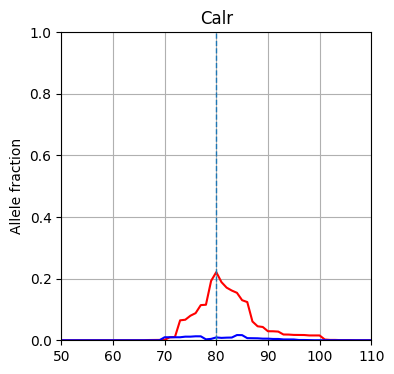

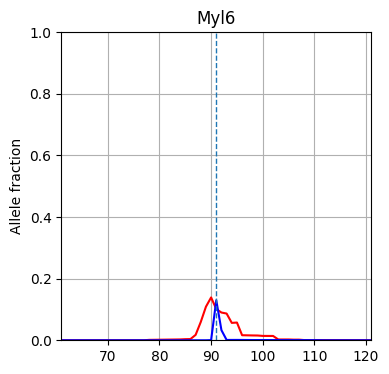

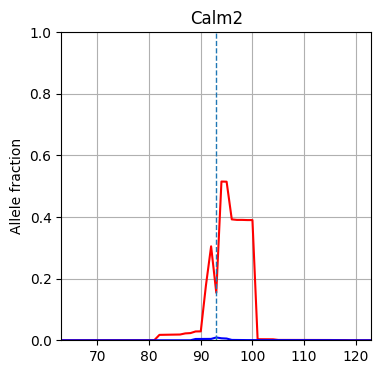

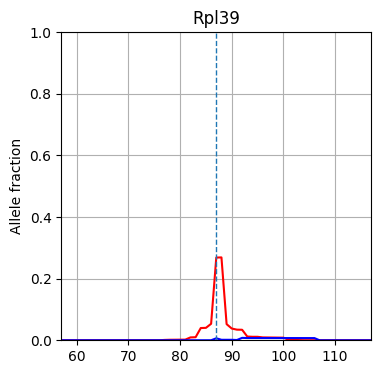

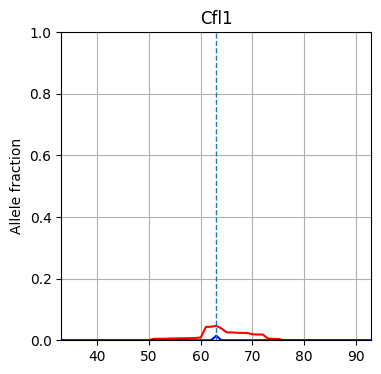

/tmp/ipykernel_219270/1258058189.py:16: RuntimeWarning: invalid value encountered in divide
  Deletion_proportion = (arr * (arr < 0)).sum(axis=0)/ sum(gene_edit_info['UMI'])
/tmp/ipykernel_219270/1258058189.py:18: RuntimeWarning: invalid value encountered in divide
  Insertion_proportion = (arr * (arr > 0)).sum(axis=0)/ sum(gene_edit_info['UMI'])


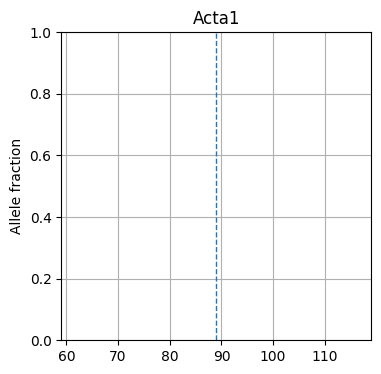

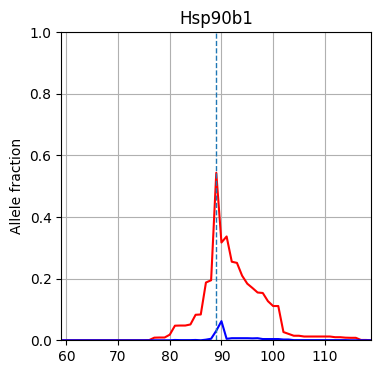

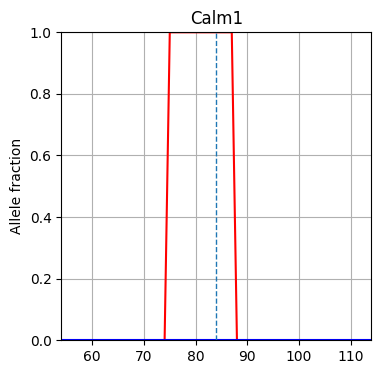

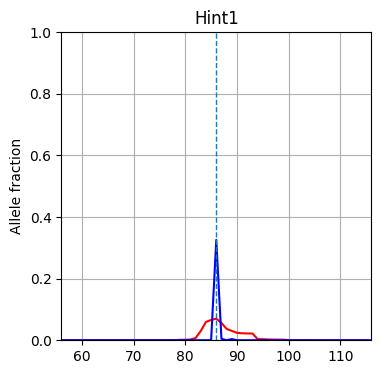

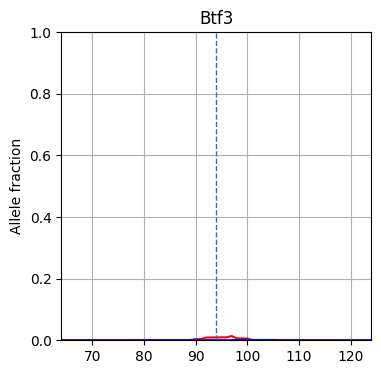

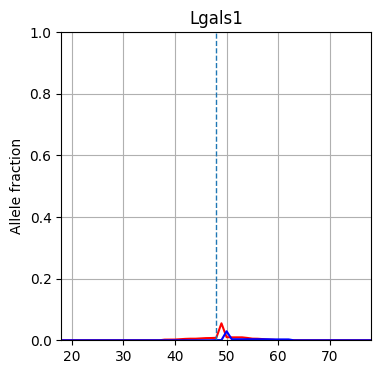

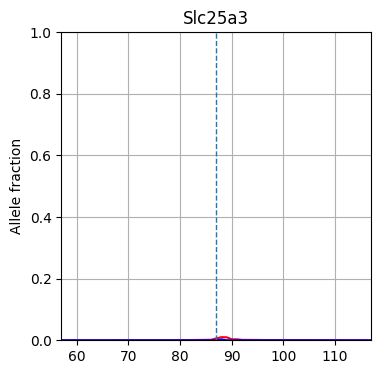

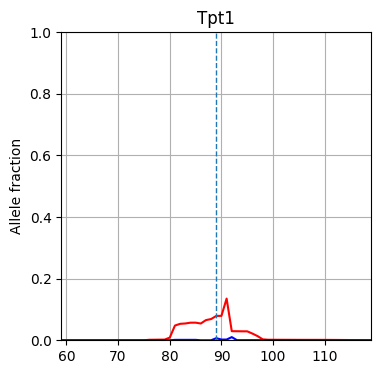

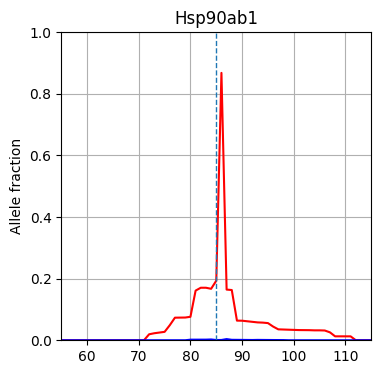

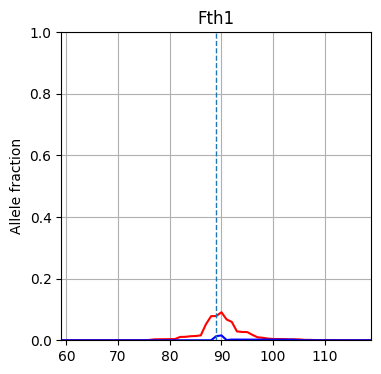

In [9]:
edit_info = allele_table
gene_names=['Calr', 'Myl6', 'Calm2', 'Rpl39', 'Cfl1', 'Acta1', 'Hsp90b1', 'Calm1', 
            'Hint1', 'Btf3', 'Lgals1', 'Slc25a3', 'Tpt1', 'Hsp90ab1', 'Fth1']
cut_sites = [80,91,93,87,63,89,89,84,86,94,48,87,89,85,89]
wc = [-17,-3,-3,-17,-3,-17,-3,-17,-3,-17,-17,-17,-17,-3,-17]
cut_sites_df = pd.DataFrame(index=gene_names)
cut_sites_df['cut_sites'] = cut_sites

for intBC in gene_names:
    gene_edit_info = edit_info[edit_info['intBC']==intBC]
    gene_edit_info = gene_edit_info.groupby(['r1'])['UMI'].sum().reset_index().sort_values(by='UMI',ascending=False)
    
    edit_matrix = edit_matrix_make(gene_edit_info)
    weights = gene_edit_info['UMI'].values.reshape(-1, 1)
    arr = edit_matrix * weights
    Deletion_proportion = (arr * (arr < 0)).sum(axis=0)/ sum(gene_edit_info['UMI'])
    Deletion_proportion = Deletion_proportion * (-1)
    Insertion_proportion = (arr * (arr > 0)).sum(axis=0)/ sum(gene_edit_info['UMI'])

    # 生成横轴：列号（从 0 开始）
    x = np.arange(arr.shape[1])

    plt.rcParams['pdf.fonttype'] = 42
    plt.gcf().set_size_inches(4, 4)
    plt.plot(x, Deletion_proportion, marker='', linestyle='-', color='red')
    plt.plot(x, Insertion_proportion, marker='', linestyle='-', color='blue')
    plt.ylabel('Allele fraction')
    plt.title('')
    plt.grid(True)
    plt.title(intBC)
    plt.ylim(0,1)
    plt.axvline(x=cut_sites_df.loc[intBC,'cut_sites'], linestyle='--', linewidth=1)
    plt.xlim(cut_sites_df.loc[intBC,'cut_sites']-30,cut_sites_df.loc[intBC,'cut_sites']+30)
    plt.savefig('/syn1/liangzhen/jinhua_jilab_project/result/Figures/Figure4/spatial_edit_distribution/'+intBC+'_'+'edit_distribution'+'.pdf')
    plt.show()